## ⚙️ Import Libraries

In [20]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [21]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


## ⏳ Load the Data (no outlier)

In [22]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

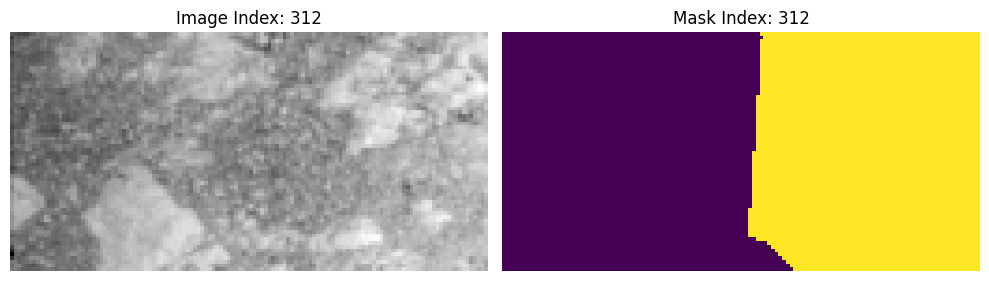

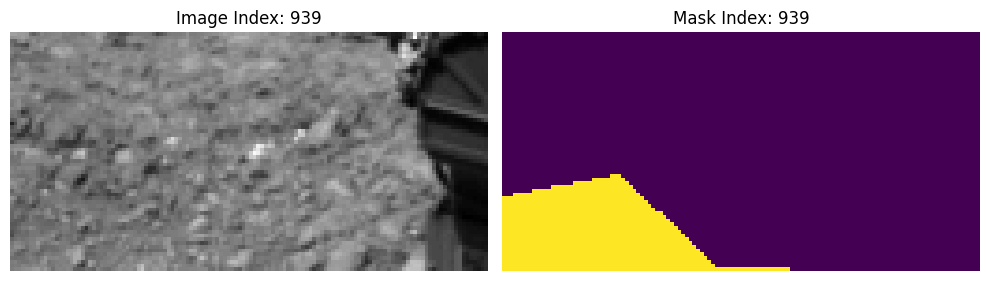

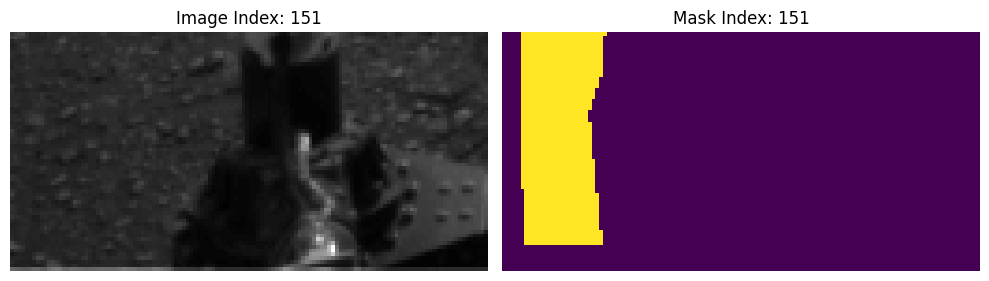

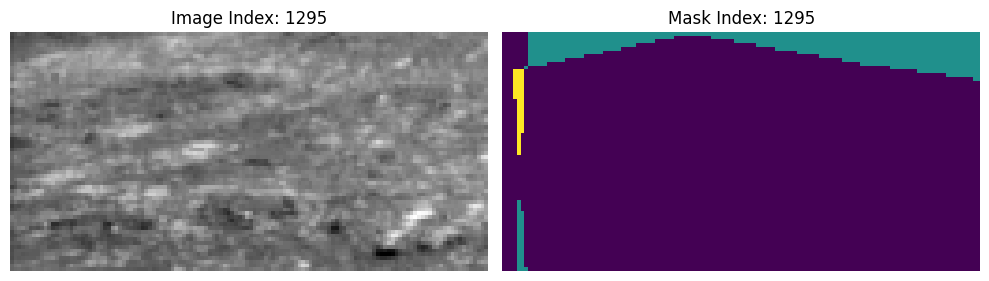

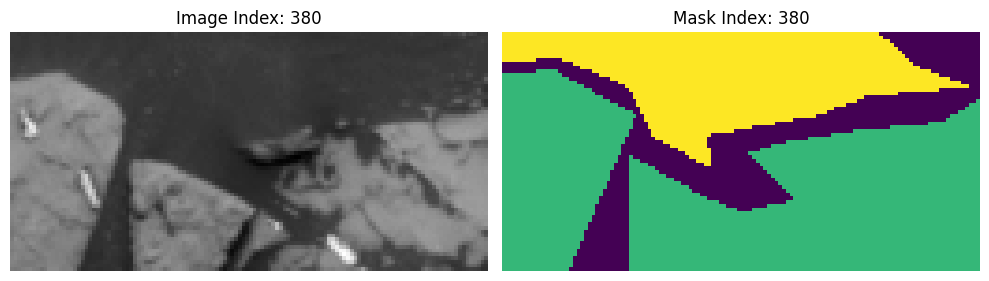

In [23]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

## invert image and noise

<ipython-input-24-df7ee1bb12d8>:88: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


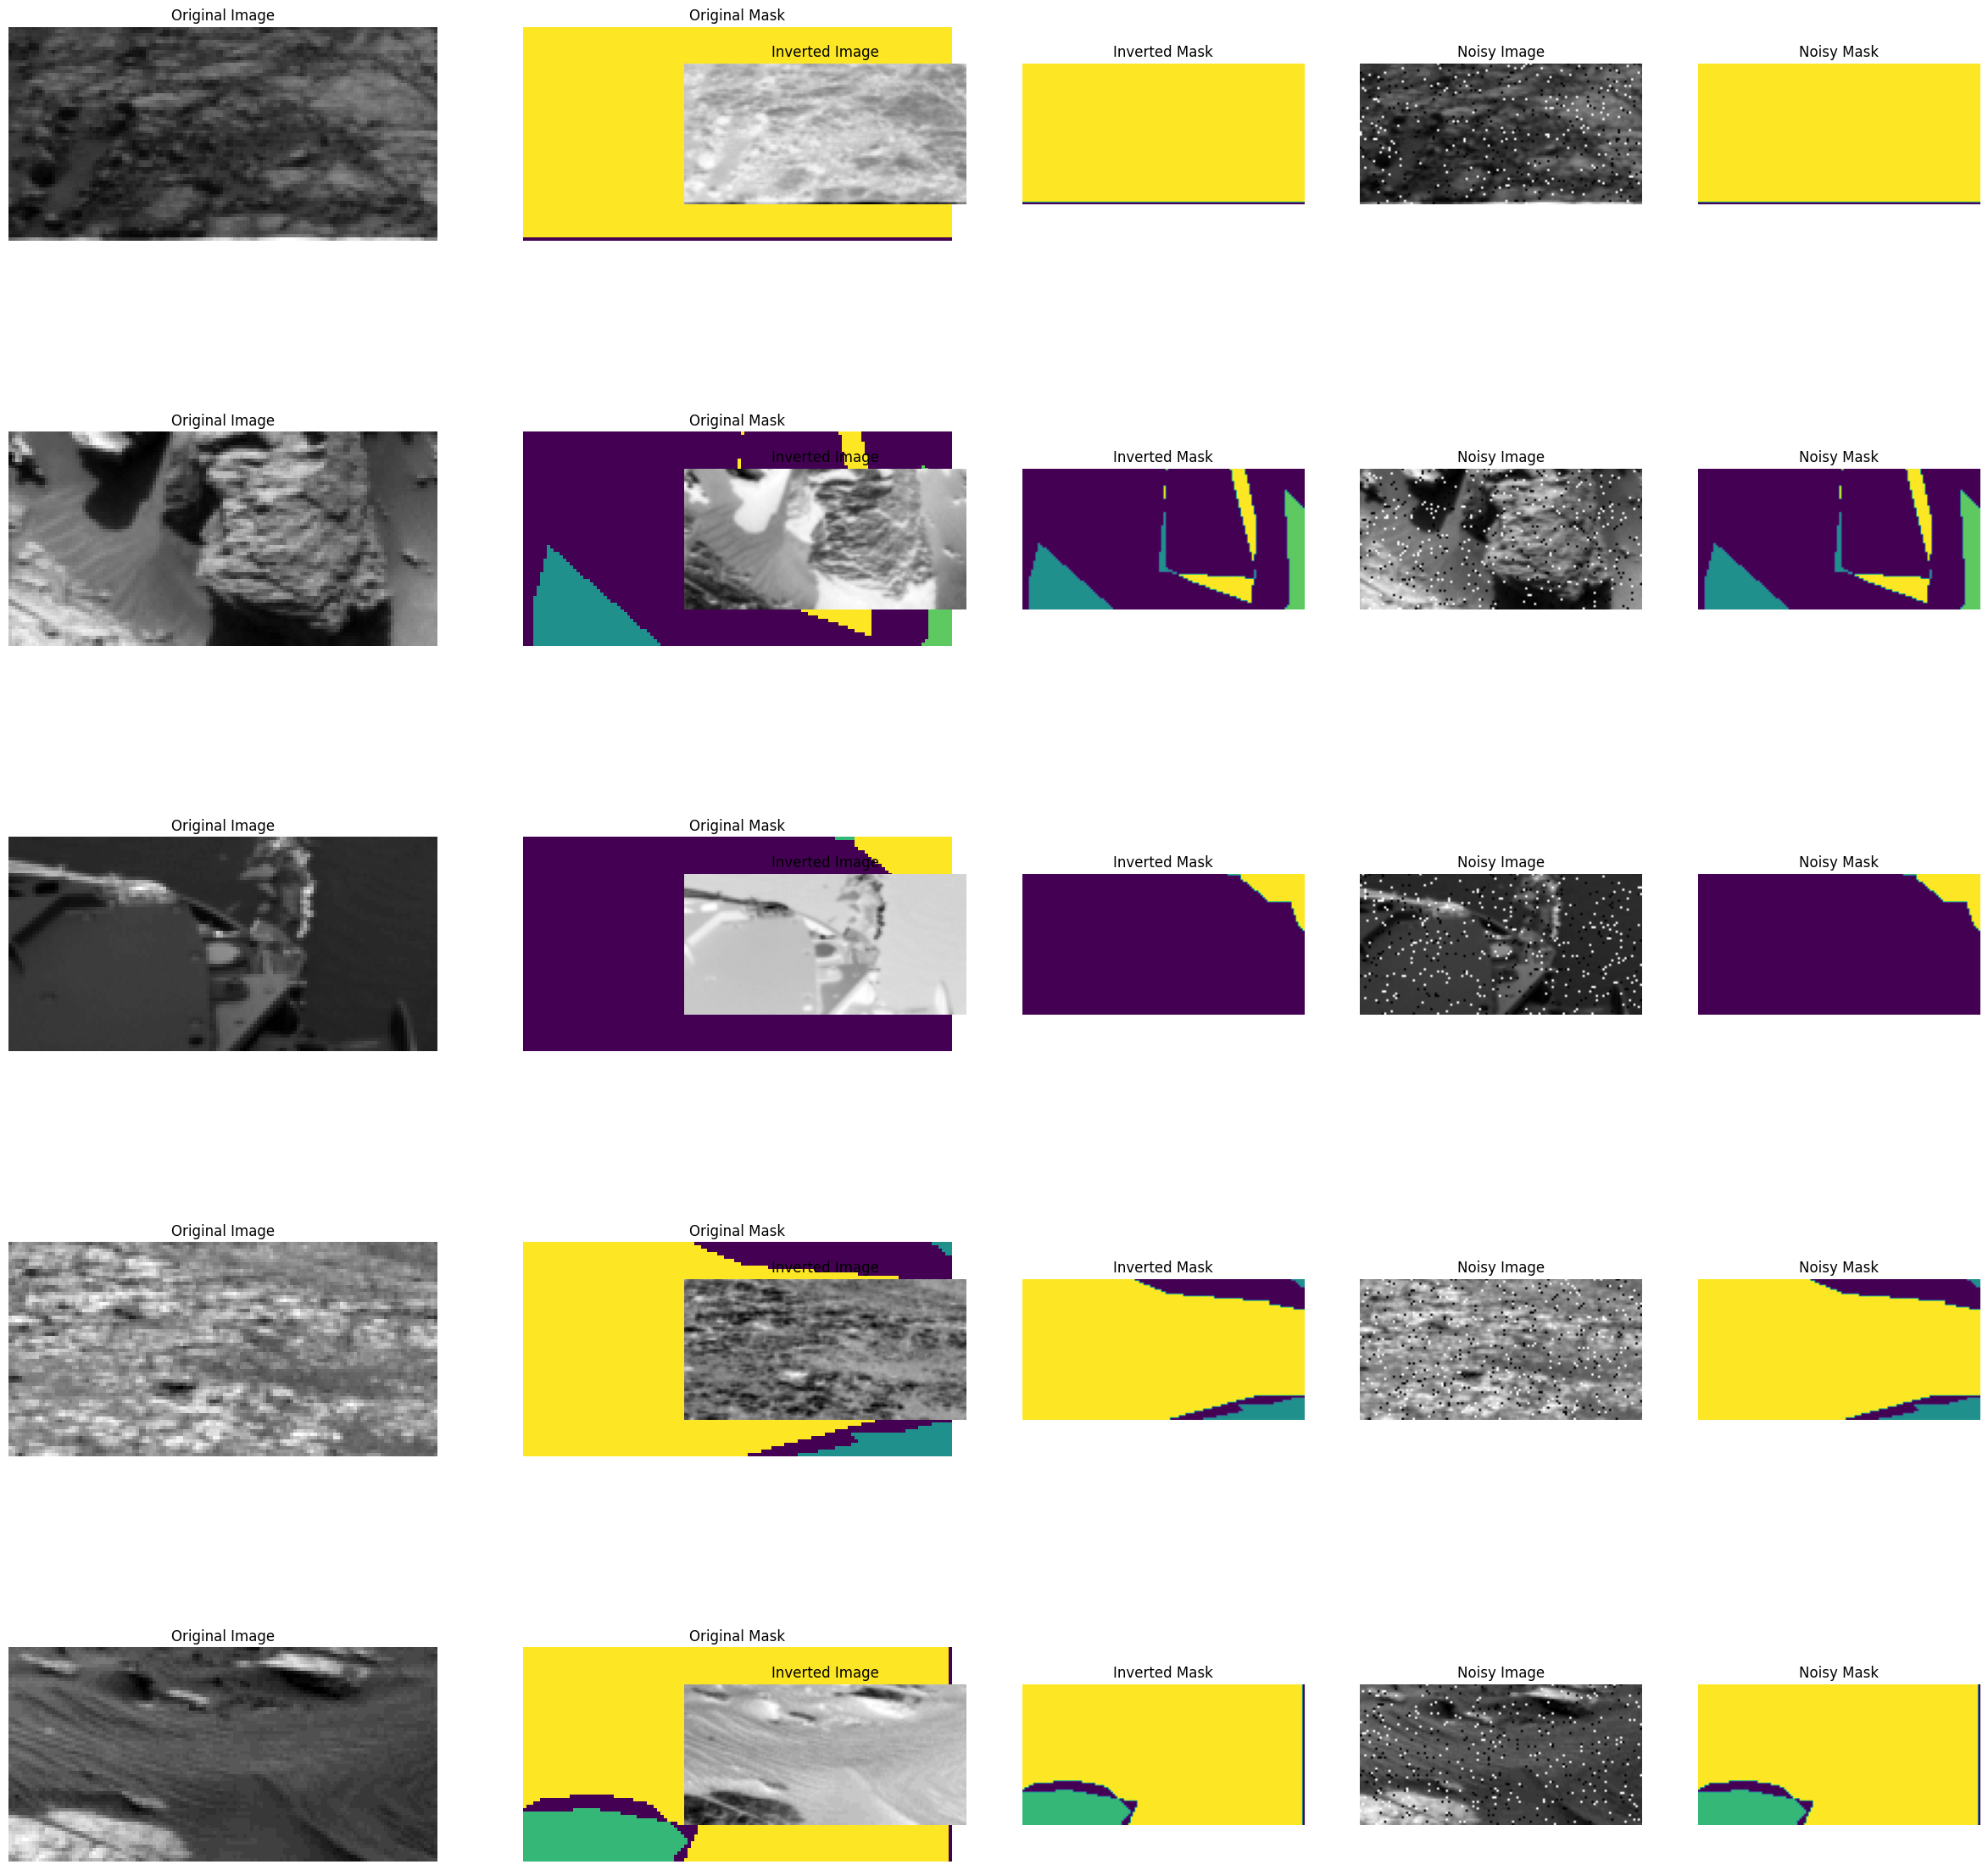

In [24]:


import numpy as np
from skimage.util import random_noise

# Define augmentation functions with mask handling
def invert_image(image, mask):
    return 255 - image, mask  # Mask remains unchanged

def add_salt_and_pepper_noise(image, mask, prob=0.03):
    """
    Add salt-and-pepper noise to an image while maintaining its original value range.

    Args:
        image (np.ndarray): Input image.
        mask (np.ndarray): Corresponding mask (unchanged).
        prob (float): Probability of noise per pixel.

    Returns:
        noisy_image (np.ndarray): Image with noise applied.
        mask (np.ndarray): Unchanged mask.
    """
    # Save the original range
    original_min = image.min()
    original_max = image.max()

    # Normalize the image to [0, 1]
    normalized_image = (image - original_min) / (original_max - original_min)

    # Generate random noise map
    random_map = np.random.random(image.shape)
    noisy_image = normalized_image.copy()
    noisy_image[random_map < prob] = 0  # Pepper
    noisy_image[random_map > (1 - prob)] = 1  # Salt

    # Rescale back to the original range
    noisy_image = noisy_image * (original_max - original_min) + original_min
    noisy_image = noisy_image.astype(image.dtype)  # Ensure the original data type is preserved

    return noisy_image, mask

"""def rotate_image(image, mask, angle):
    rotated_image = rotate(image, angle, reshape=False, mode='constant', cval=0)
    rotated_mask = rotate(mask, angle, reshape=False, mode='constant', order=0)
    return rotated_image, rotated_mask"""
"""
def adjust_brightness(image, mask, factor=1.2):
    brightened_image = np.clip(image * factor, 0, 255).astype(np.uint8)
    return brightened_image, mask  # Mask remains unchanged"""

# Visualize augmentations with masks
def visualize_all_augmentations(images, masks):
    plt.figure(figsize=(30, 30))
    for i, (image, mask) in enumerate(zip(images, masks)):
        # Original image and mask
        plt.subplot(len(images), 4, i * 4 + 1)
        plt.imshow(image, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(len(images), 4, i * 4 + 2)
        plt.imshow(mask, cmap="viridis")
        plt.title("Original Mask")
        plt.axis("off")

        # Inversion
        inverted_image, inverted_mask = invert_image(image, mask)
        plt.subplot(len(images), 6, i * 6 + 3)
        plt.imshow(inverted_image, cmap="gray")
        plt.title("Inverted Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 4)
        plt.imshow(inverted_mask, cmap="viridis")
        plt.title("Inverted Mask")
        plt.axis("off")

        # Noise
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        plt.subplot(len(images), 6, i * 6 + 5)
        plt.imshow(noisy_image, cmap="gray")
        plt.title("Noisy Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 6)
        plt.imshow(noisy_mask, cmap="viridis")
        plt.title("Noisy Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Randomly select 5 samples from the dataset
random_indices = np.random.choice(len(X_train), size=5, replace=False)
sample_images = X_train[random_indices]
sample_masks = y_train[random_indices]

# Visualize augmentations
visualize_all_augmentations(sample_images, sample_masks)


### rotation

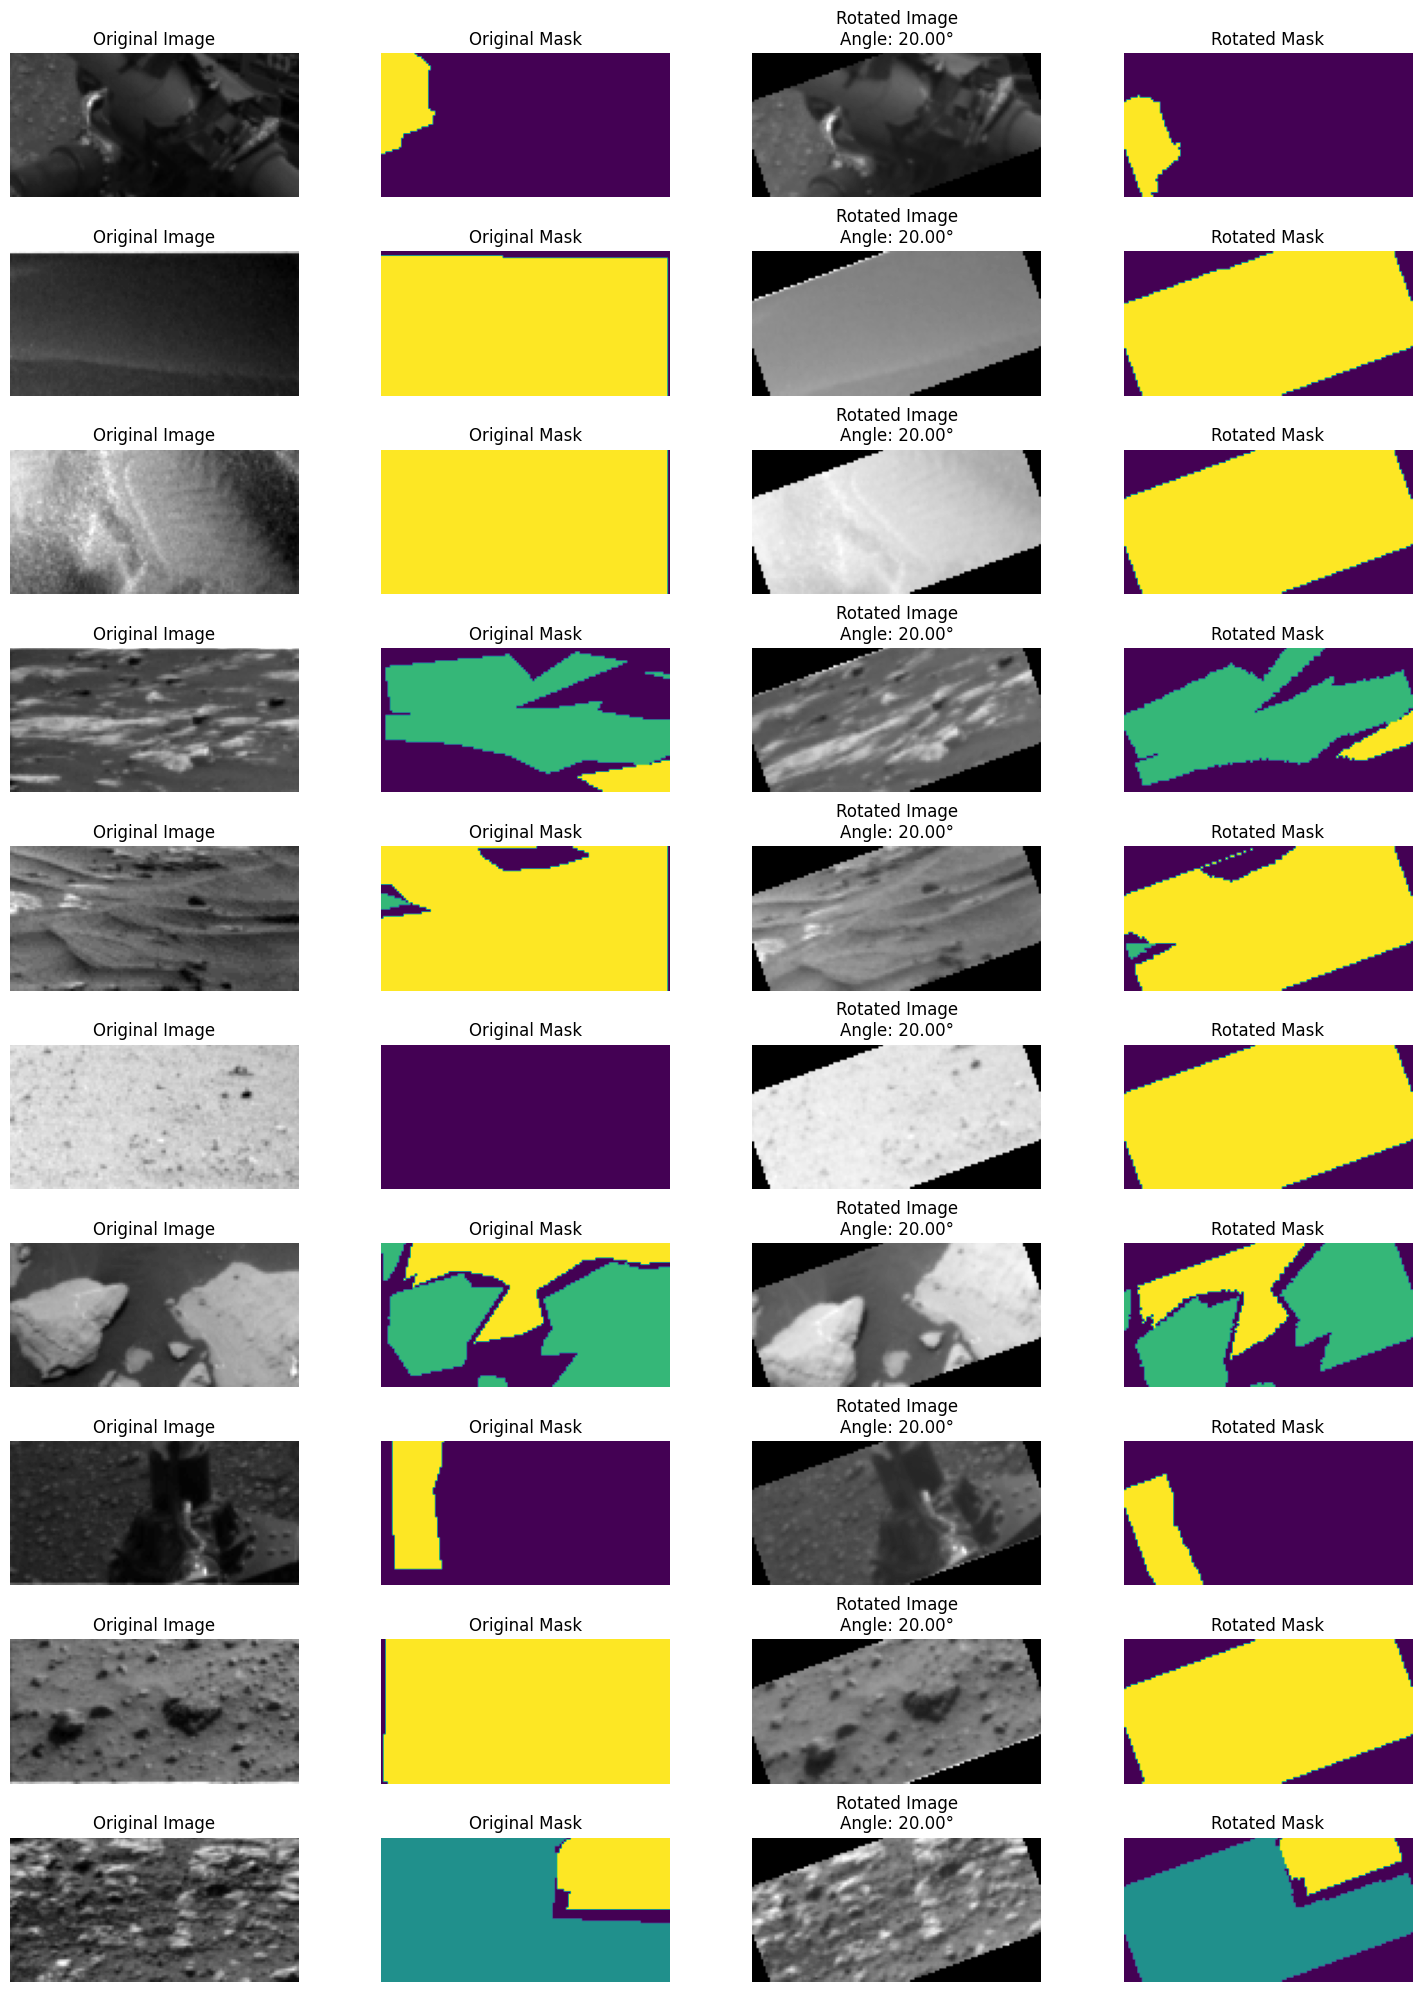

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define the rotation function using scipy
def rotate_image_and_mask(image, mask, angle):
    """
    Rotate a grayscale image and its corresponding mask by a given angle.
    """
    # Rotate the grayscale image (bilinear interpolation)
    rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

    # Rotate the mask (nearest-neighbor interpolation)
    rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

    return rotated_image, rotated_mask

# Randomly select 10 images
random_indices = np.random.choice(len(X_train), size=10, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply random rotation and visualize
plt.figure(figsize=(15, 20))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Generate a random angle for rotation
    angle = np.random.uniform(20, 20)  # Random angle between -30° and 30°

    # Rotate the image and mask
    rotated_image, rotated_mask = rotate_image_and_mask(image, mask, angle)

    # Plot original and rotated images/masks
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Rotated Image\nAngle: {angle:.2f}°")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(rotated_mask, cmap="viridis")
    plt.title("Rotated Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


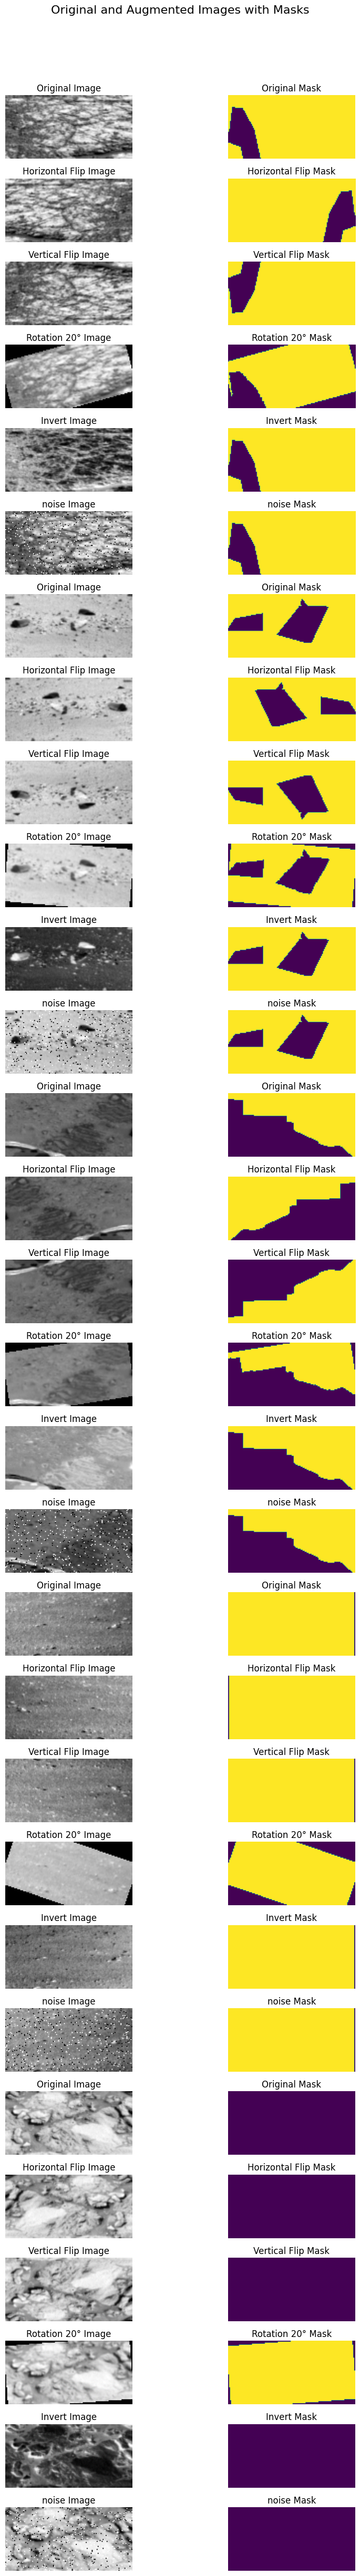

In [26]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    elif augment_type == "Rotation 20°":
        angle = np.random.uniform(-20, 20)
        # Rotate the grayscale image (bilinear interpolation)
        rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

        # Rotate the mask (nearest-neighbor interpolation)
        rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

        return rotated_image, rotated_mask
    elif augment_type=="Invert":
        inverted_image, inverted_mask = invert_image(image, mask)
        return inverted_image,inverted_mask
    elif augment_type=="noise":
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        return noisy_image,noisy_mask

    """elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    "Rotation 20°": "Rotation 20°",
    "Invert":"Invert",
    "noise":"noise"
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [27]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_train, y_train):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


File: zoom_(0.8-1.2).npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


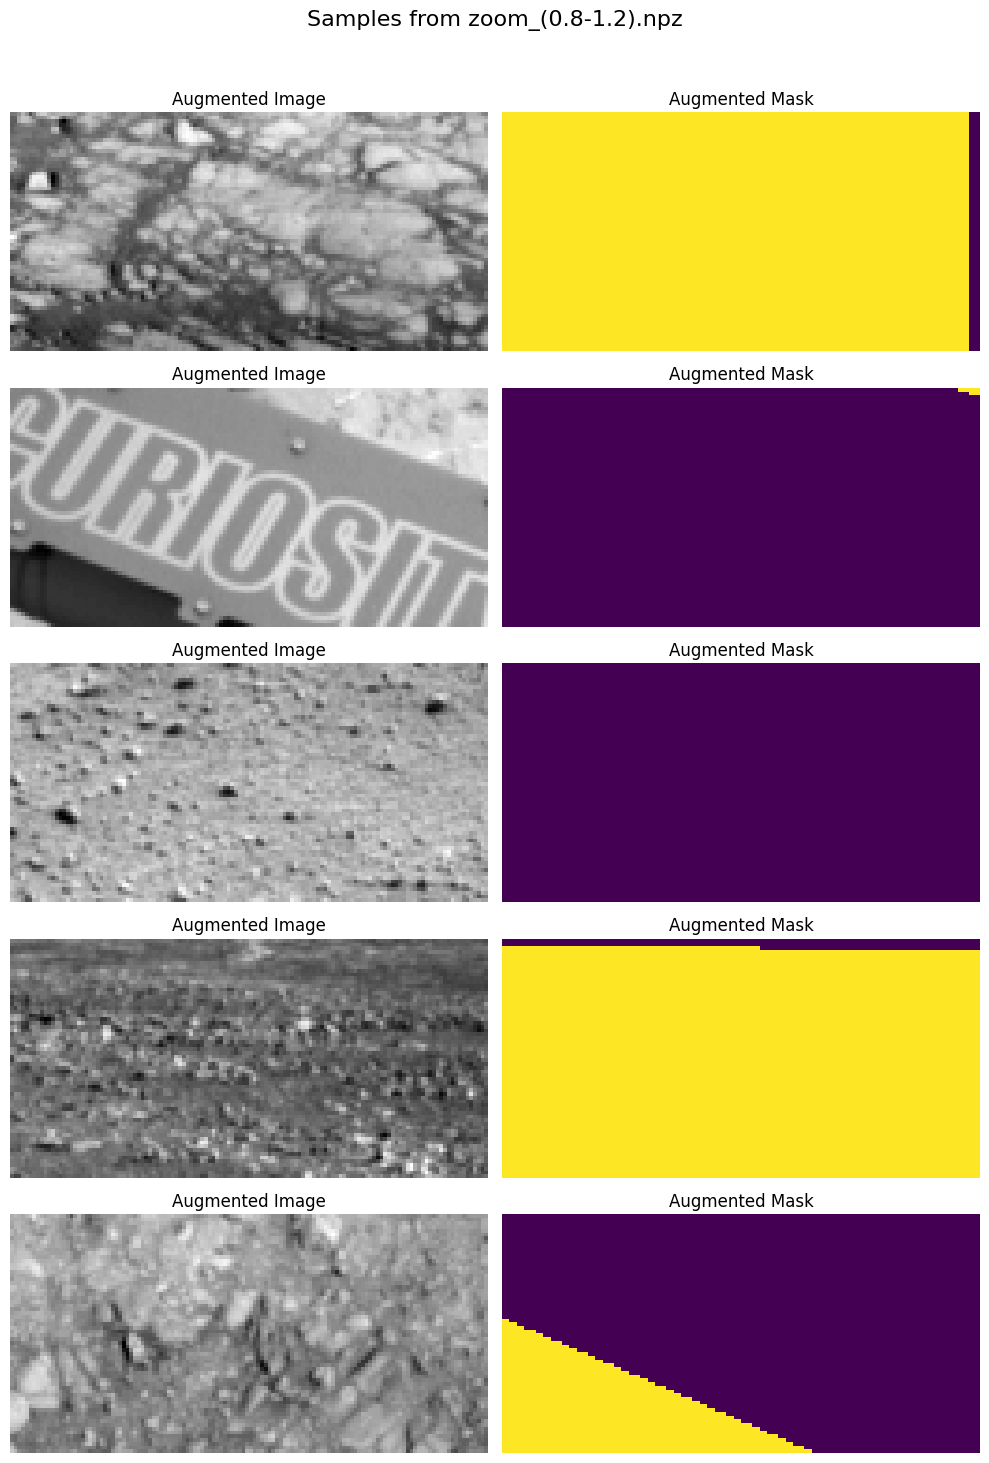

File: shift_(width_and_height).npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


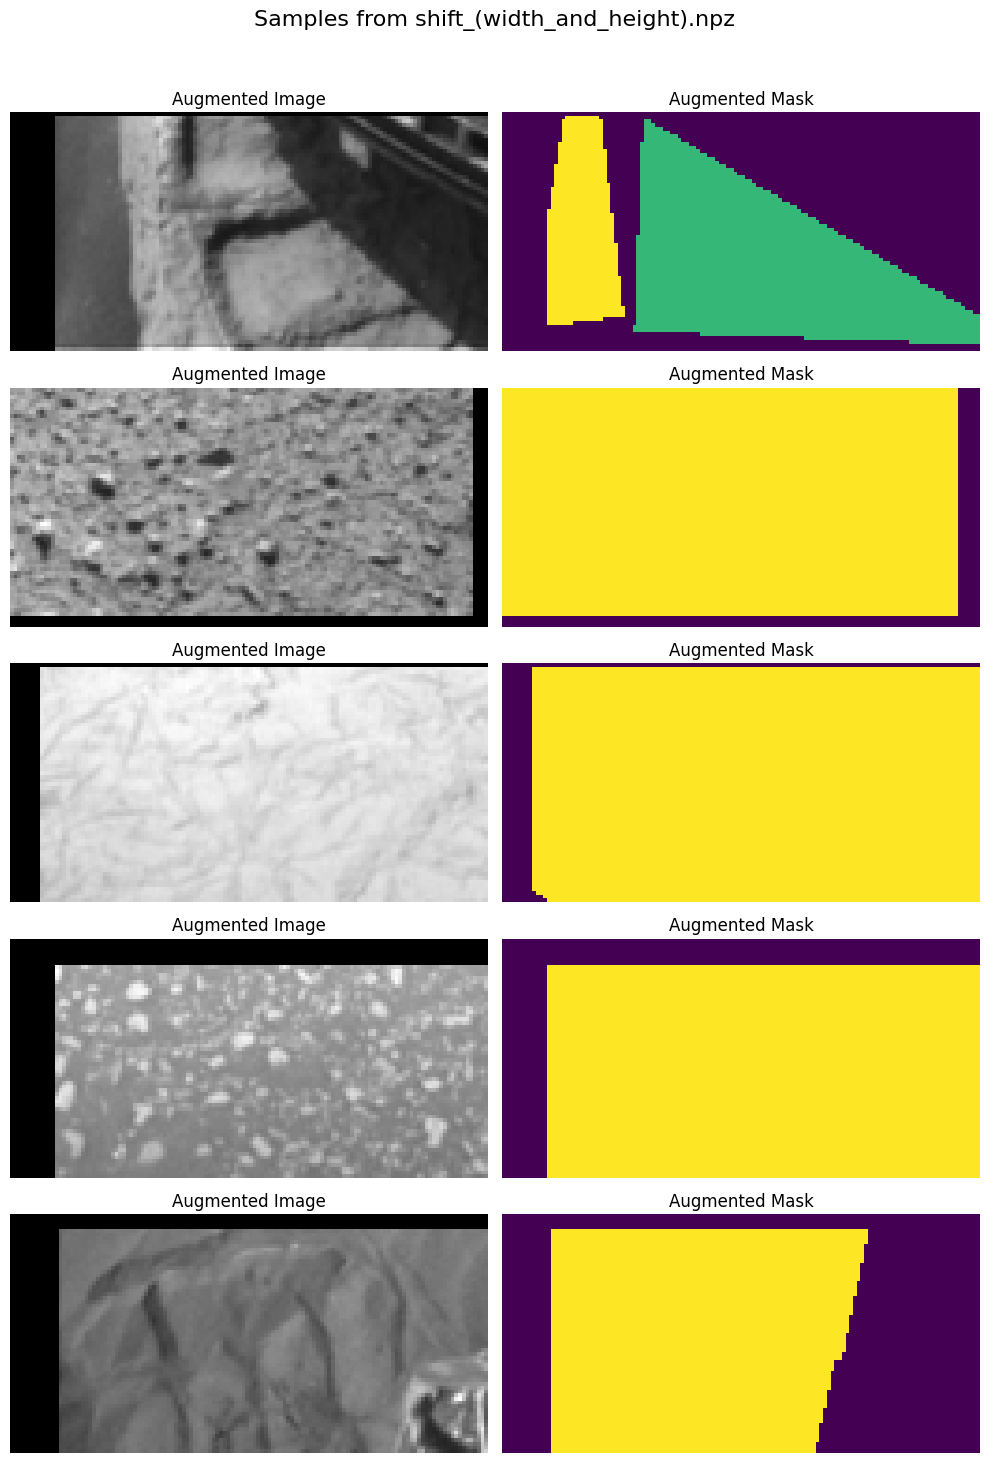

File: rotation_30°.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


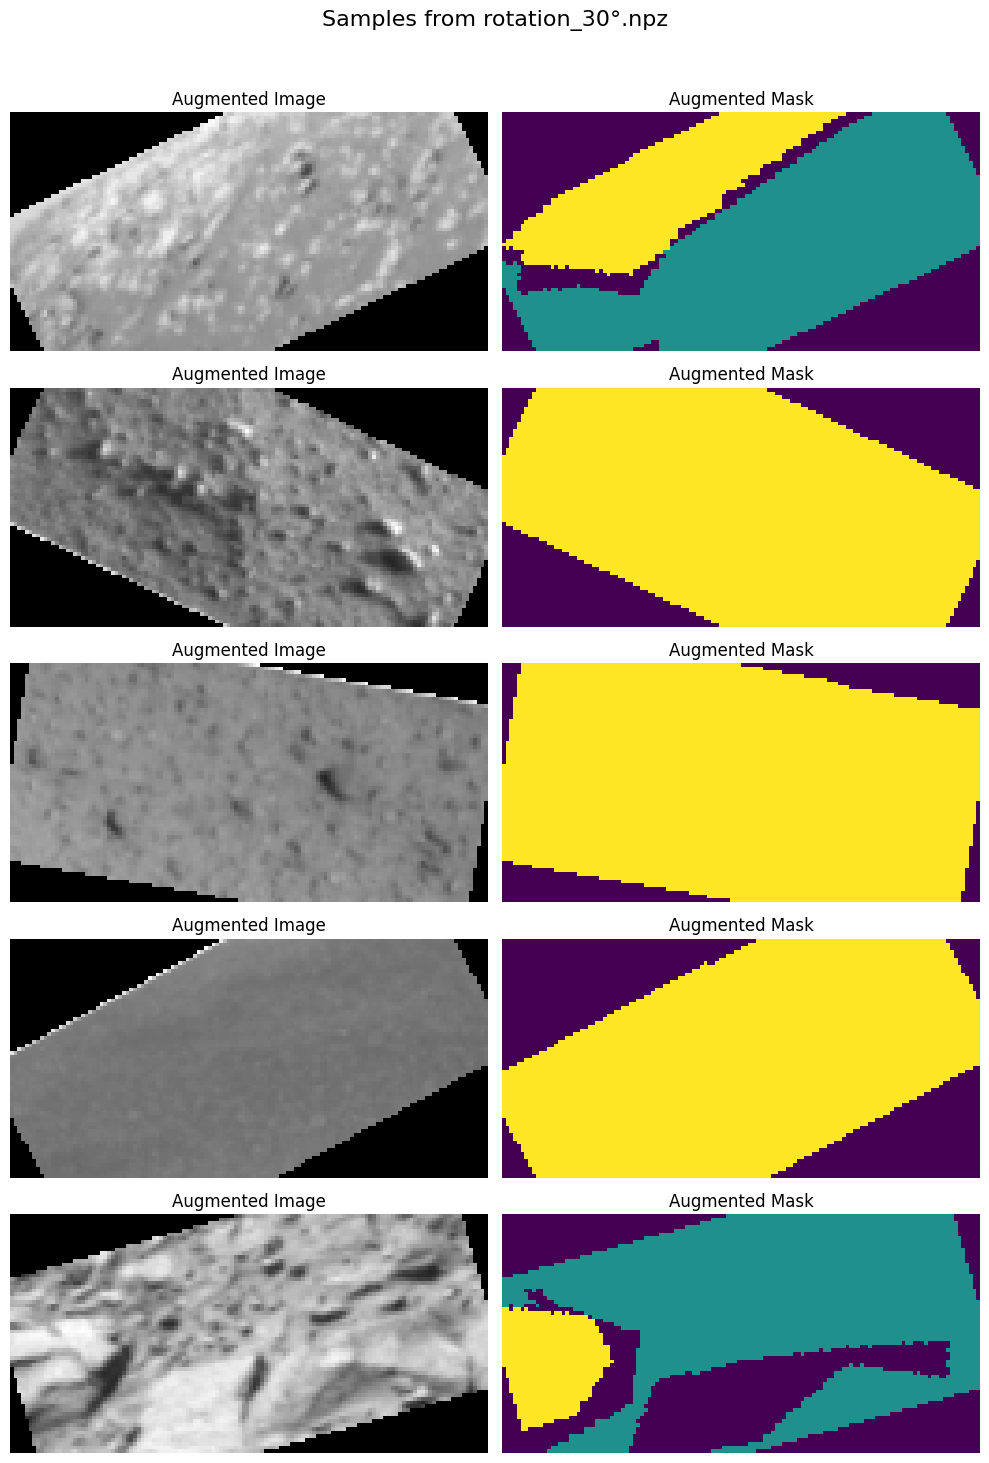

File: horizontal_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


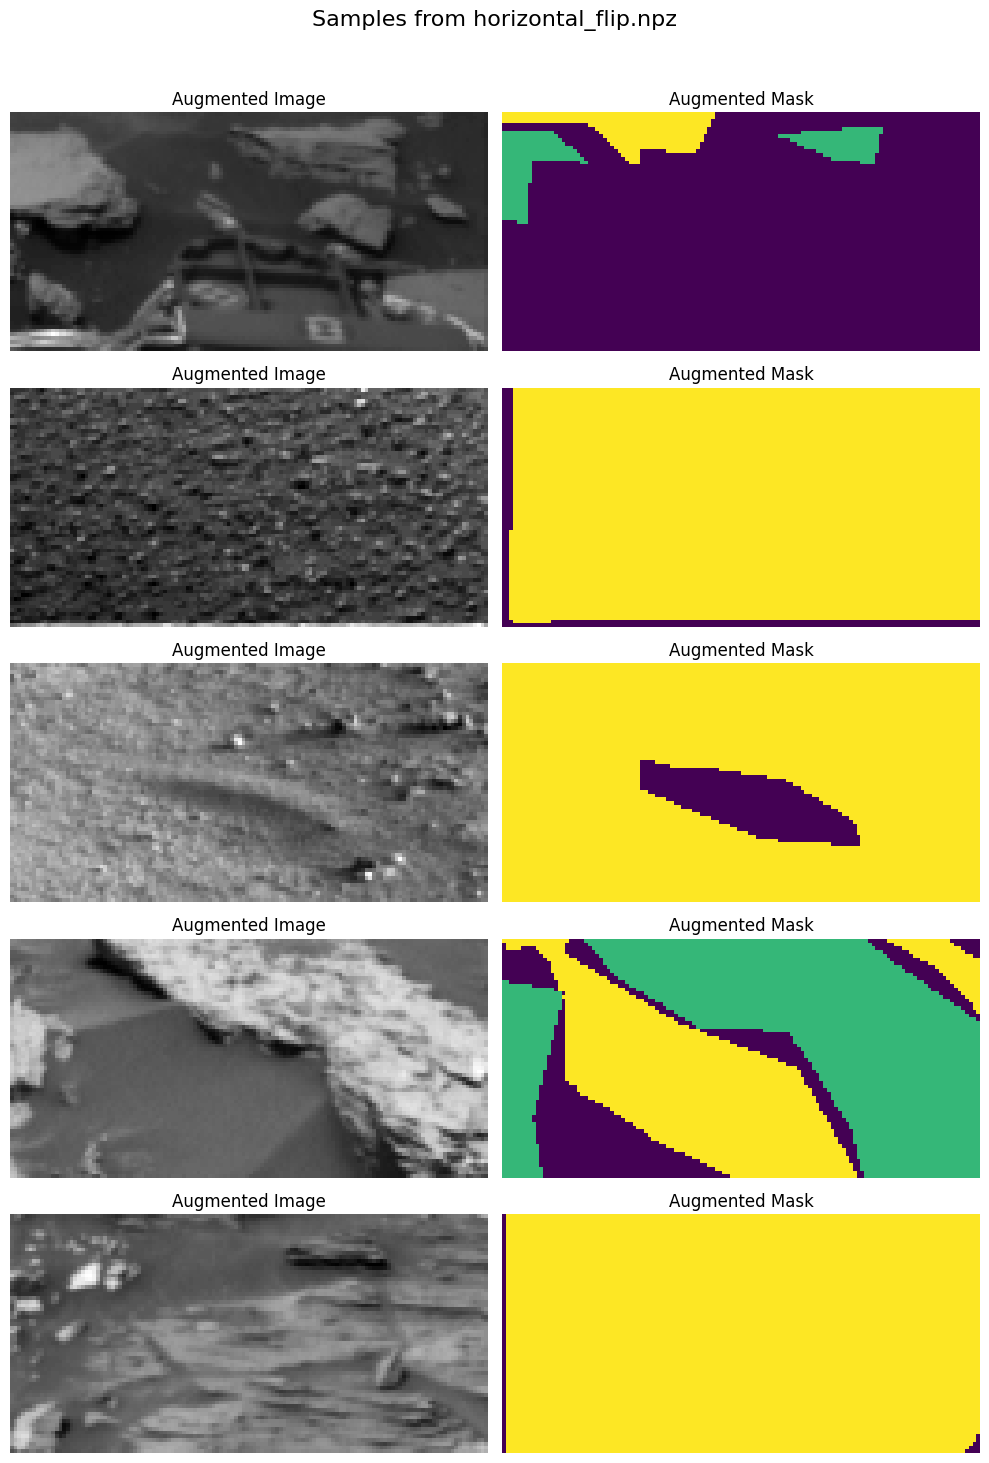

File: vertical_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


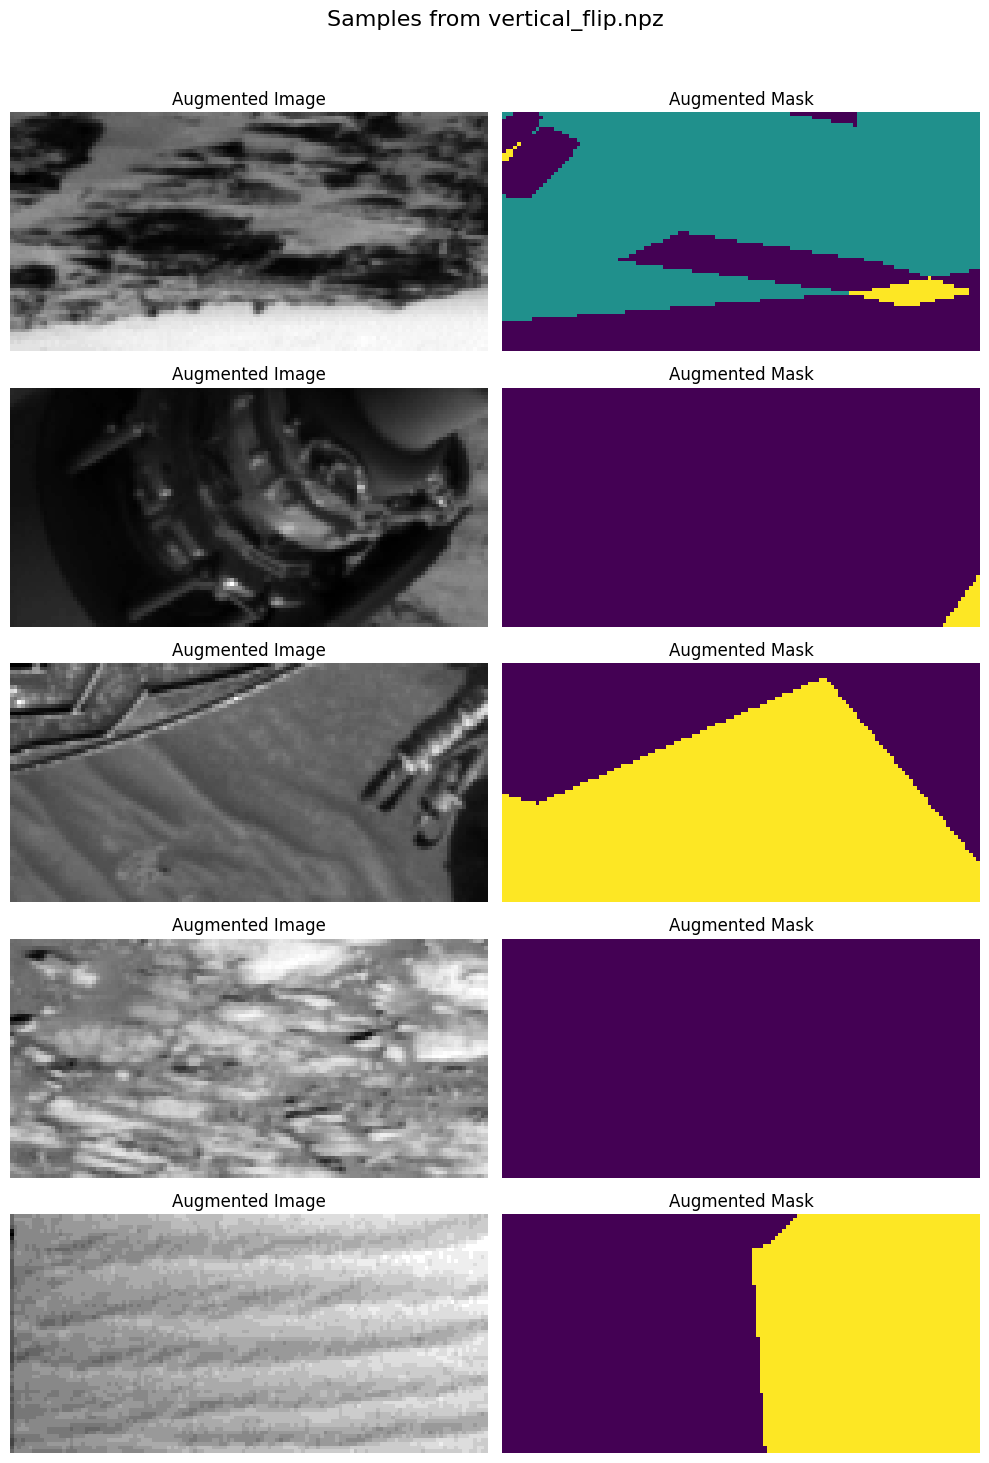

File: rotation_20°.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


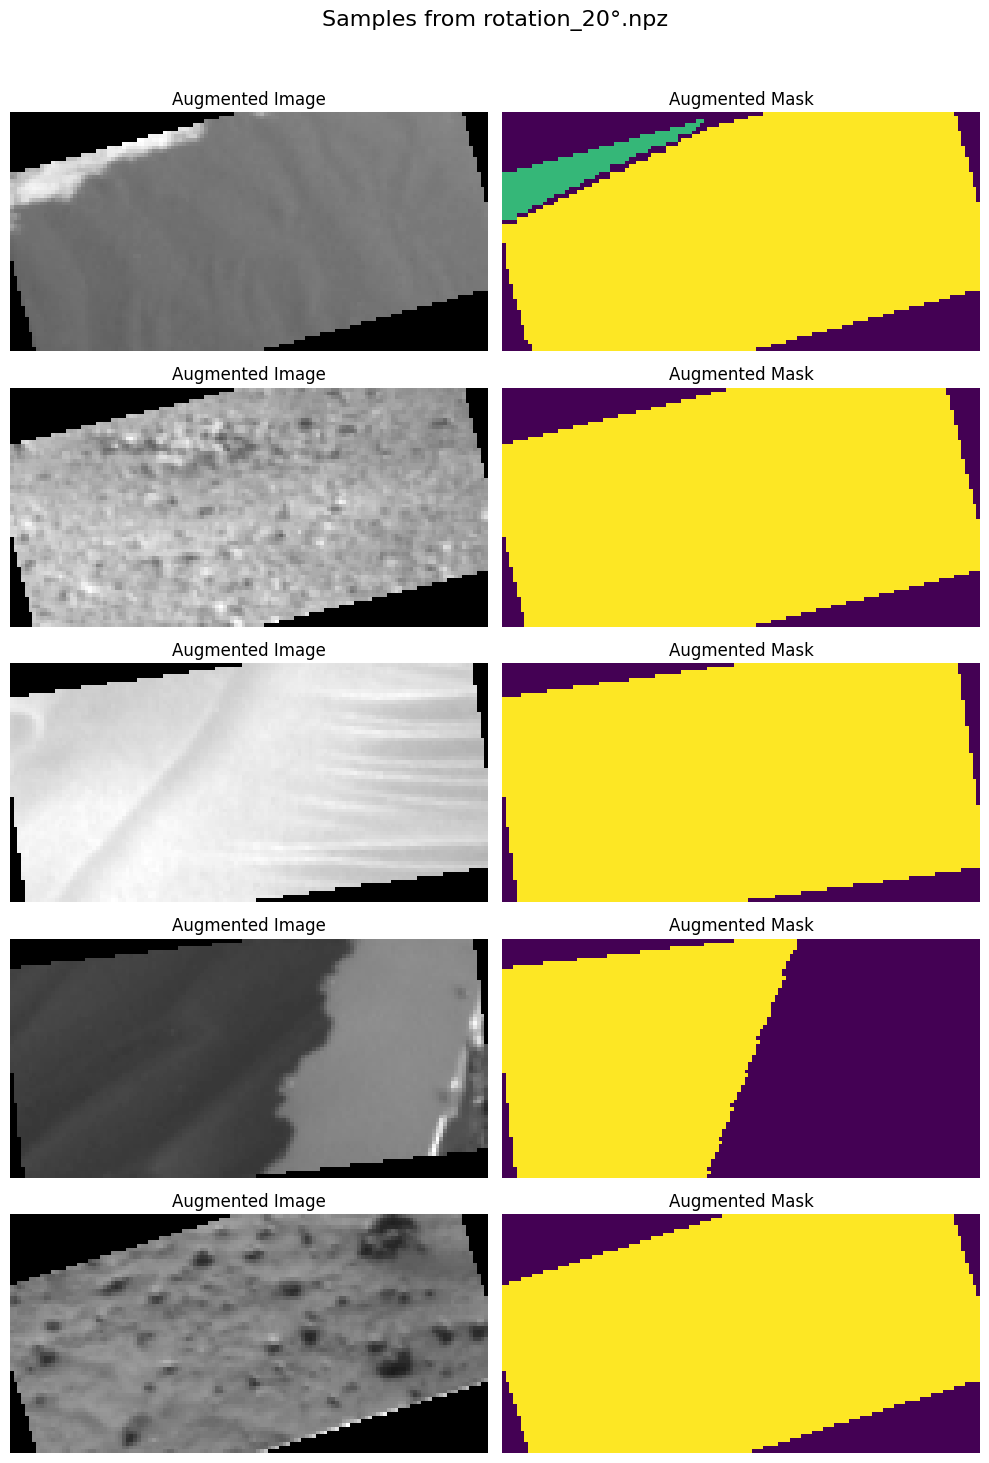

File: invert.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


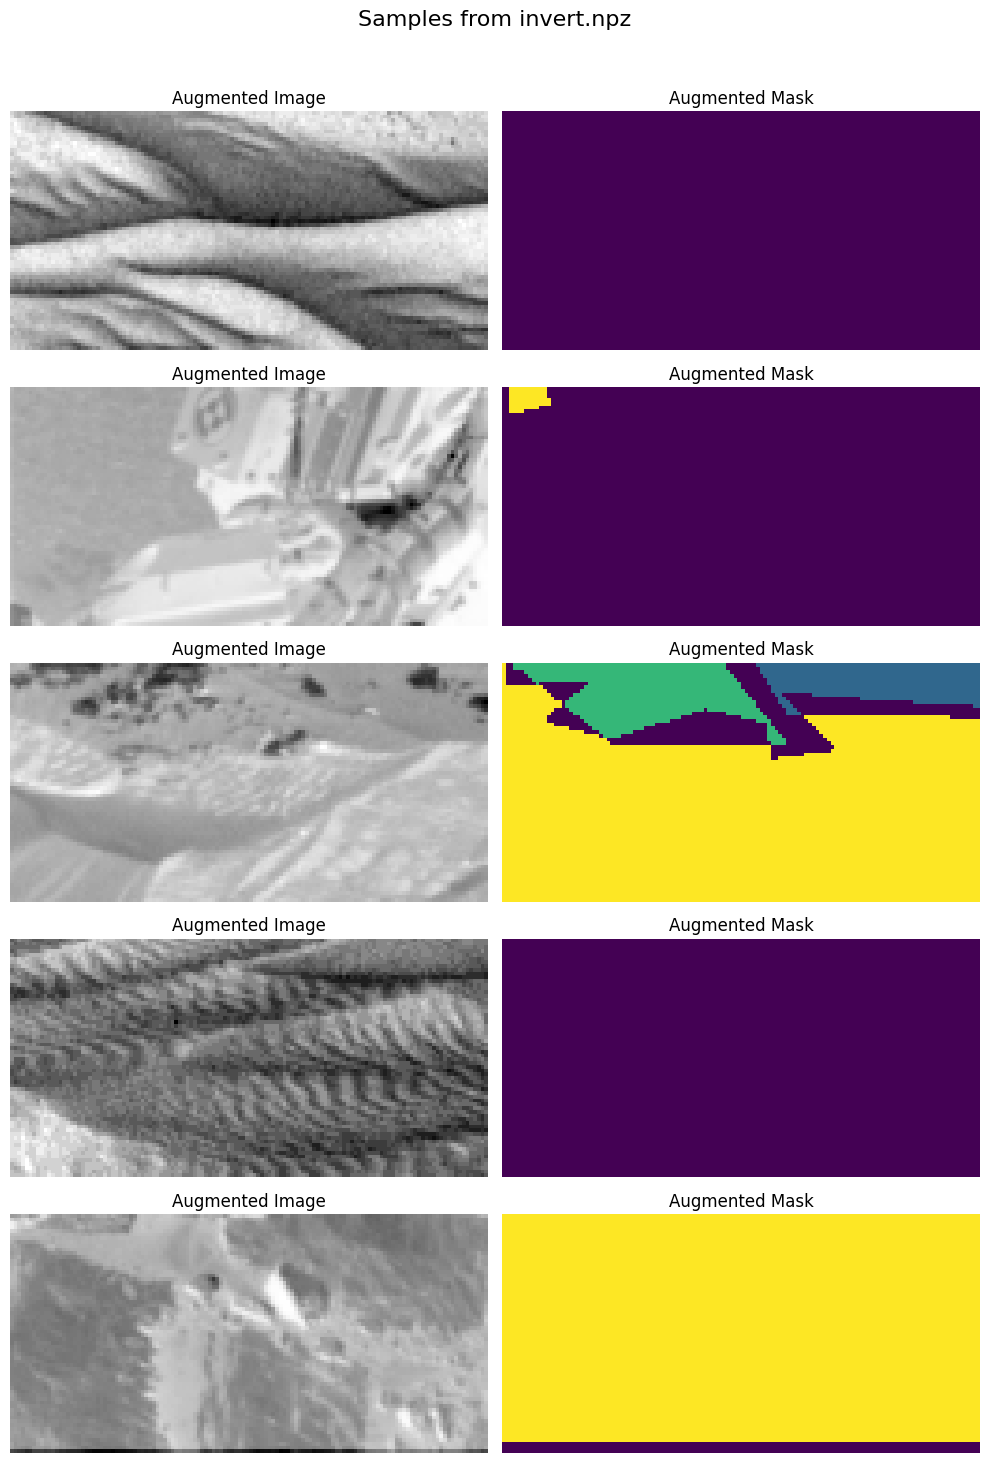

File: noise.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


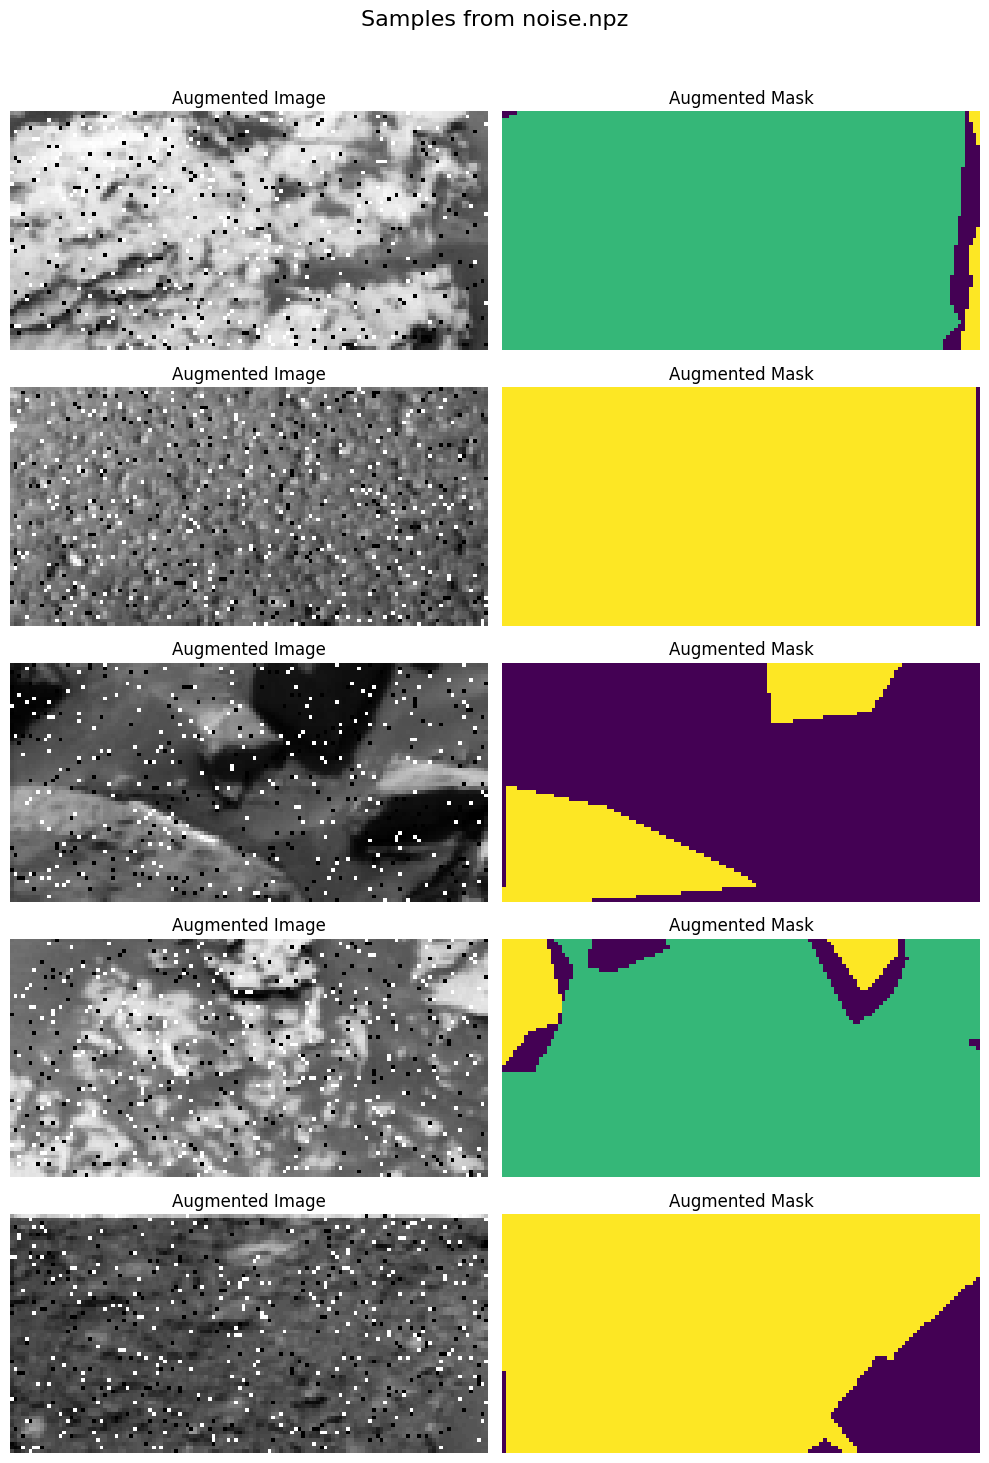

In [28]:
# Read the saved files and display details
output_dir="augmented_data"
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
        file_path = os.path.join(output_dir, file_name)
        data = np.load(file_path)

        # Display keys and their shapes
        print(f"File: {file_name}")
        for key in data.keys():
            print(f"  Key: {key}, Shape: {data[key].shape}")

        # Plot 5 random images and masks
        fig, axes = plt.subplots(5, 2, figsize=(10, 15))
        fig.suptitle(f"Samples from {file_name}", fontsize=16)
        for i in range(5):
            random_idx = np.random.randint(data["augmented_images"].shape[0])
            axes[i, 0].imshow(data["augmented_images"][random_idx], cmap="gray")
            axes[i, 0].set_title("Augmented Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(data["augmented_masks"][random_idx])
            axes[i, 1].set_title("Augmented Mask")
            axes[i, 1].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [29]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data_val"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_val, y_val):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


## 🛠️ Train and Save the Model

In [31]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("augmented_data/horizontal_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (4008, 64, 128)
New y_train shape: (4008, 64, 128)


In [32]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("augmented_data_val/horizontal_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_val = np.concatenate([X_val, augmented_images], axis=0)
y_val = np.concatenate([y_val, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_val.shape}")
print(f"New y_train shape: {y_val.shape}")

New X_train shape: (1002, 64, 128)
New y_train shape: (1002, 64, 128)


In [33]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("augmented_data/vertical_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (6012, 64, 128)
New y_train shape: (6012, 64, 128)


In [34]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("augmented_data_val/vertical_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_val = np.concatenate([X_val, augmented_images], axis=0)
y_val = np.concatenate([y_val, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_val.shape}")
print(f"New y_train shape: {y_val.shape}")

New X_train shape: (1503, 64, 128)
New y_train shape: (1503, 64, 128)


In [35]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("augmented_data/rotation_20°.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (8016, 64, 128)
New y_train shape: (8016, 64, 128)


In [36]:
# Load the rotation augmentation dataset
"""rotation_file_path = os.path.join("augmented_data_val/rotation_20°.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_val = np.concatenate([X_val, augmented_images], axis=0)
y_val = np.concatenate([y_val, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_val.shape}")
print(f"New y_train shape: {y_val.shape}")"""

'rotation_file_path = os.path.join("augmented_data_val/rotation_20°.npz")\nrotation_data = np.load(rotation_file_path)\n\n# Extract augmented images and masks\naugmented_images = rotation_data["augmented_images"]\naugmented_masks = rotation_data["augmented_masks"]\n\n# Merge with original X_train and y_train\nX_val = np.concatenate([X_val, augmented_images], axis=0)\ny_val = np.concatenate([y_val, augmented_masks], axis=0)\n\n# Display the new shapes\nprint(f"New X_train shape: {X_val.shape}")\nprint(f"New y_train shape: {y_val.shape}")'

In [37]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("augmented_data/invert.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (10020, 64, 128)
New y_train shape: (10020, 64, 128)


In [38]:
# Load the rotation augmentation dataset
"""rotation_file_path = os.path.join("augmented_data_val/invert.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_val = np.concatenate([X_val, augmented_images], axis=0)
y_val = np.concatenate([y_val, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_val.shape}")
print(f"New y_train shape: {y_val.shape}")"""

'rotation_file_path = os.path.join("augmented_data_val/invert.npz")\nrotation_data = np.load(rotation_file_path)\n\n# Extract augmented images and masks\naugmented_images = rotation_data["augmented_images"]\naugmented_masks = rotation_data["augmented_masks"]\n\n# Merge with original X_train and y_train\nX_val = np.concatenate([X_val, augmented_images], axis=0)\ny_val = np.concatenate([y_val, augmented_masks], axis=0)\n\n# Display the new shapes\nprint(f"New X_train shape: {X_val.shape}")\nprint(f"New y_train shape: {y_val.shape}")'

In [39]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("augmented_data/noise.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (12024, 64, 128)
New y_train shape: (12024, 64, 128)


In [40]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [41]:
X_val = X_val[..., np.newaxis] / 255.0

In [42]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (12024, 64, 128, 1)
X_val shape: (1503, 64, 128, 1)
y_train shape: (12024, 64, 128)


In [43]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis",vmin=0,vmax=4)
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis",vmin=0,vmax=4)
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [44]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (12024, 64, 128, 1)
Shape of y_train after reshaping: (12024, 64, 128, 1)


In [45]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (1503, 64, 128, 1)
Shape of y_train after reshaping: (1503, 64, 128, 1)


In [46]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=30,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)




Shape of X_train after reshaping: (12024, 64, 128, 1)
Shape of y_train after reshaping: (12024, 64, 128)
Class pixel counts: [25080450 32652638 23178115 17464095   125310]
Calculated class weights: [0.00489157 0.00375721 0.00529304 0.00702485 0.97903334]


In [47]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [48]:
from tensorflow.keras.callbacks import Callback
class SaveBestMeanIoU(Callback):
    def __init__(self, filepath, monitor="val_mean_io_u", mode="max", verbose=1):
        super(SaveBestMeanIoU, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = -float("inf") if mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Debug: Print available keys in logs
        print(f"Available log keys: {logs.keys()}")

        # Use the correct log key
        current = logs.get(self.monitor)
        if current is None:
            if self.verbose > 0:
                print(f"Warning: Monitor '{self.monitor}' is not available in logs.")
            return

        if (self.mode == "max" and current > self.best) or (self.mode == "min" and current < self.best):
            self.best = current
            if self.verbose > 0:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current:.4f}, saving model.")
            self.model.save(self.filepath)


Class Weights: [0.         0.00377567 0.00531906 0.00705938 0.98384589]


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_176 (Conv2D)       │ (None, 64, 128, 64)    │            640 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_177 (Conv2D)       │ (None, 64, 128, 64)    │         36,928 │ conv2d_176[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_178 (Conv2D)       │ (None, 64, 128, 64)    │            128 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_56 (Add)              │ (None, 64, 128, 64)    │              0 │ conv2d_177[0][0],      │
│                           │                        │                │ conv2d_178[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 32, 64, 64)     │              0 │ add_56[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_179 (Conv2D)       │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_180 (Conv2D)       │ (None, 32, 64, 128)    │        147,584 │ conv2d_179[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_181 (Conv2D)       │ (None, 32, 64, 128)    │          8,320 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_57 (Add)              │ (None, 32, 64, 128)    │              0 │ conv2d_180[0][0],      │
│                           │                        │                │ conv2d_181[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 16, 32, 128)    │              0 │ add_57[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_182 (Conv2D)       │ (None, 16, 32, 256)    │        295,168 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_183 (Conv2D)       │ (None, 16, 32, 256)    │        590,080 │ conv2d_182[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_184 (Conv2D)       │ (None, 16, 32, 256)    │         33,024 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_58 (Add)              │ (None, 16, 32, 256)    │              0 │ conv2d_183[0][0],      │
│                           │                        │                │ conv2d_184[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 8, 16, 256)     │              0 │ add_58[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3039 - loss: 0.1045 - mean_iou: 0.1081

Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 1: val_mean_iou improved to 0.1956, saving model.

Epoch 1: val_loss improved from inf to 0.07717, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


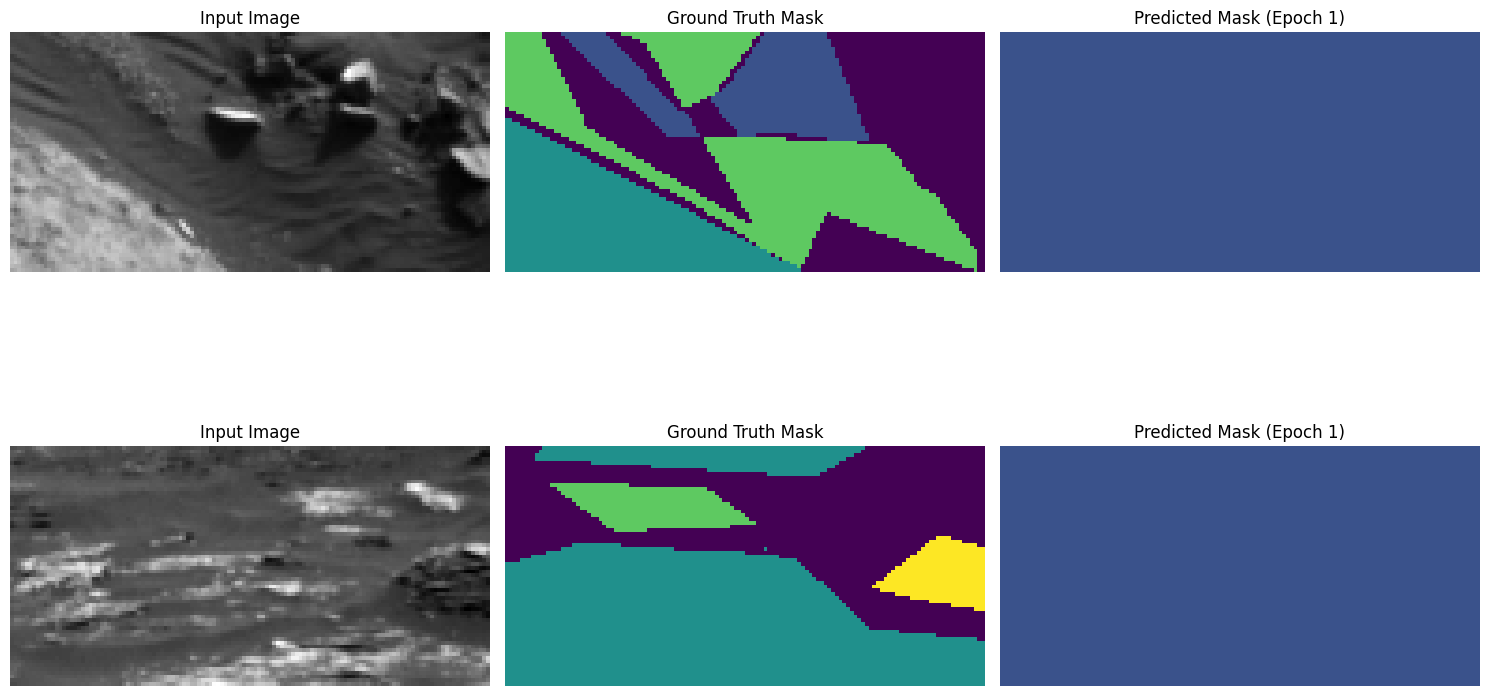

376/376 ━━━━━━━━━━━━━━━━━━━━ 156s 370ms/step - accuracy: 0.3039 - loss: 0.1045 - mean_iou: 0.1081 - val_accuracy: 0.3944 - val_loss: 0.0772 - val_mean_iou: 0.1956 - learning_rate: 1.0000e-04
Epoch 2/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3737 - loss: 0.0747 - mean_iou: 0.2383

Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 2: val_mean_iou improved to 0.3315, saving model.

Epoch 2: val_loss improved from 0.07717 to 0.05717, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


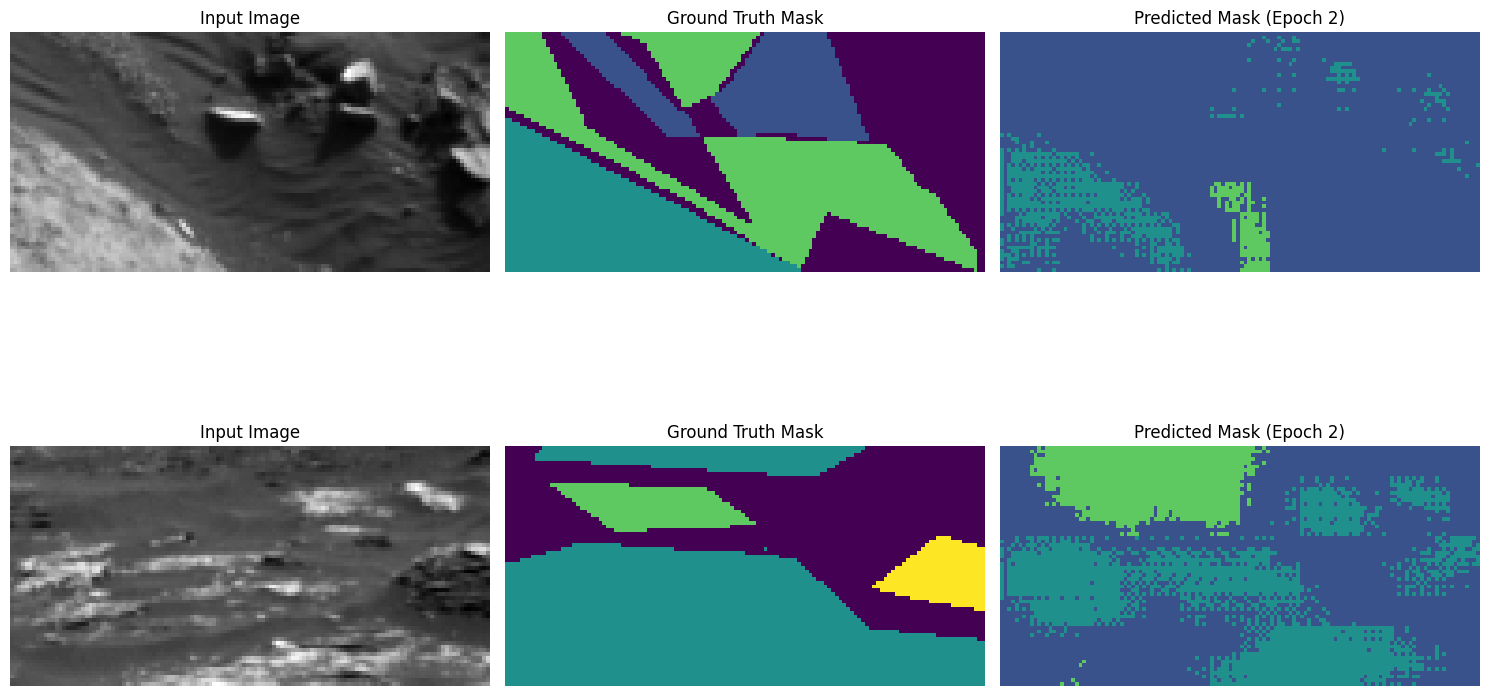

376/376 ━━━━━━━━━━━━━━━━━━━━ 80s 213ms/step - accuracy: 0.3737 - loss: 0.0747 - mean_iou: 0.2383 - val_accuracy: 0.4517 - val_loss: 0.0572 - val_mean_iou: 0.3315 - learning_rate: 1.0000e-04
Epoch 3/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3962 - loss: 0.0646 - mean_iou: 0.2703Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 3: val_loss improved from 0.05717 to 0.05460, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


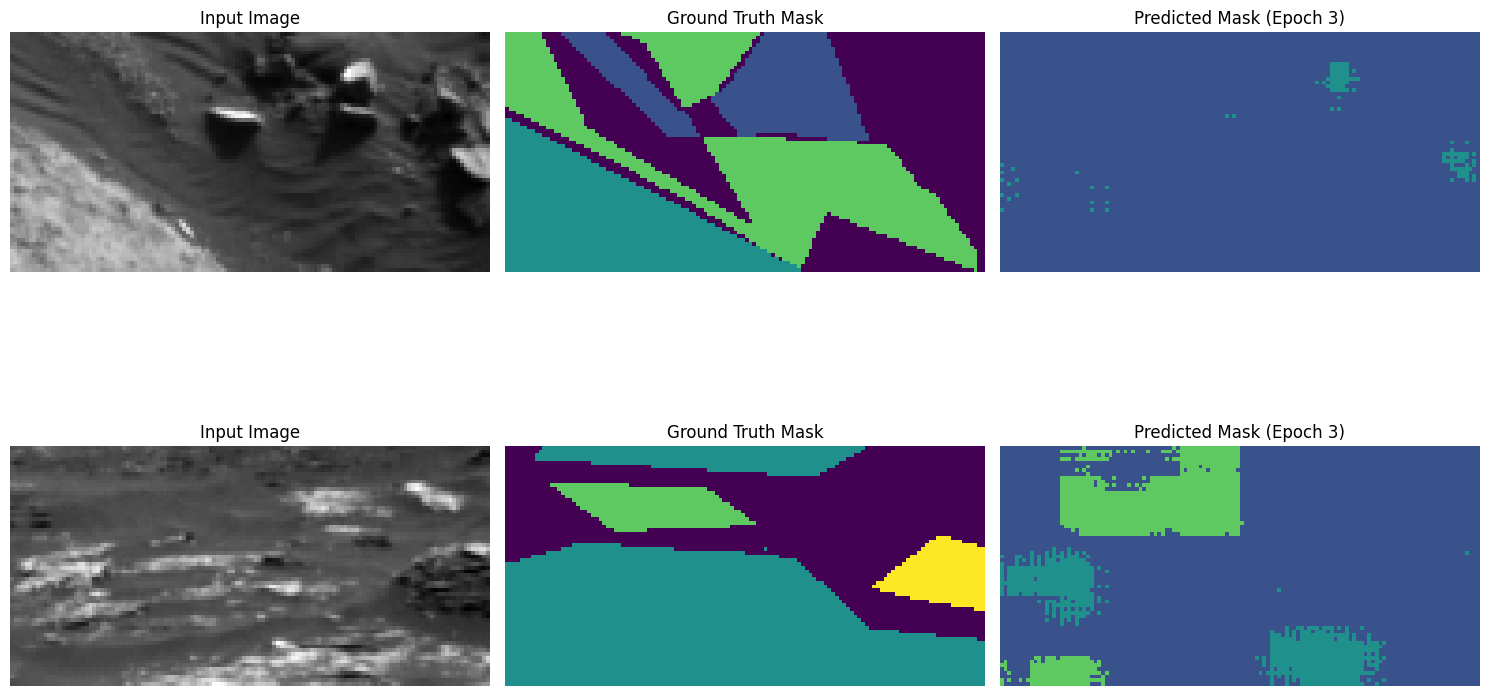

376/376 ━━━━━━━━━━━━━━━━━━━━ 76s 201ms/step - accuracy: 0.3963 - loss: 0.0646 - mean_iou: 0.2704 - val_accuracy: 0.4717 - val_loss: 0.0546 - val_mean_iou: 0.3274 - learning_rate: 1.0000e-04
Epoch 4/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.4329 - loss: 0.0592 - mean_iou: 0.3102

Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 4: val_mean_iou improved to 0.3929, saving model.

Epoch 4: val_loss improved from 0.05460 to 0.05295, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


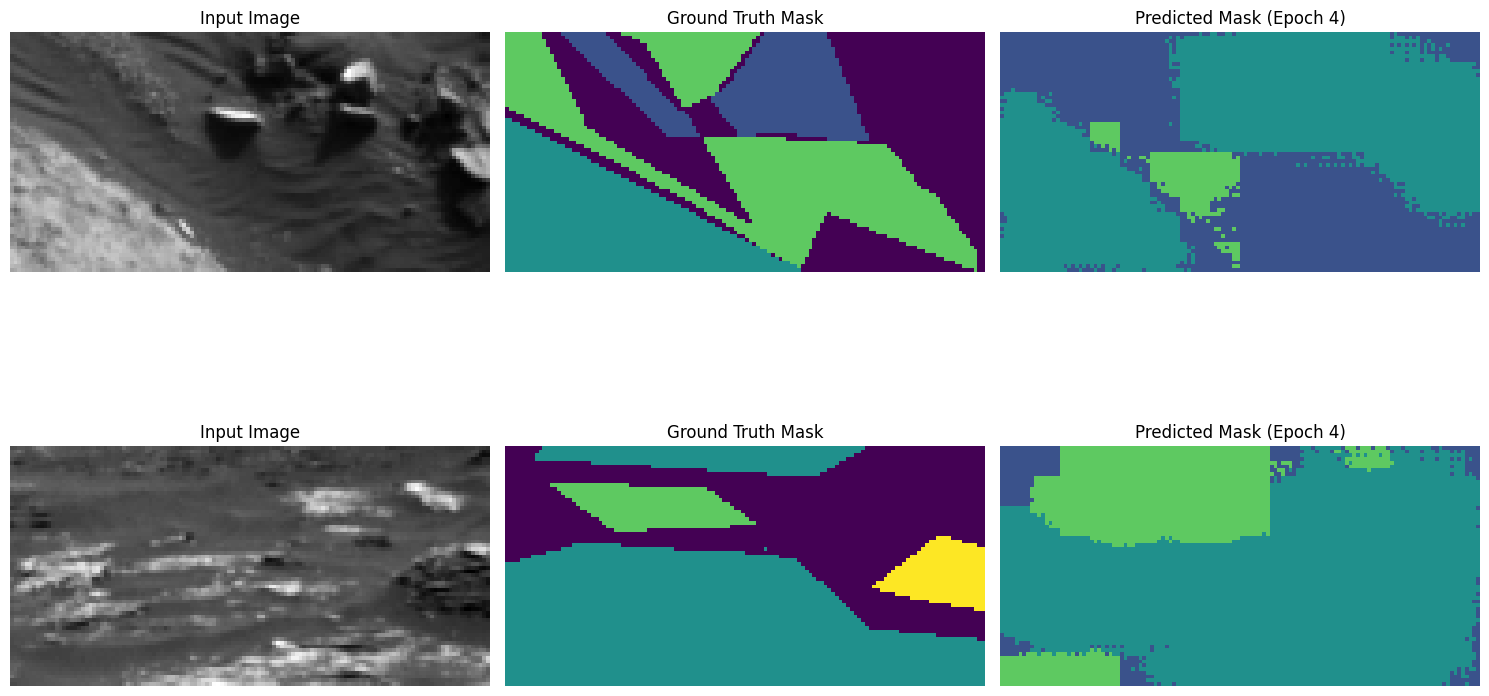

376/376 ━━━━━━━━━━━━━━━━━━━━ 84s 208ms/step - accuracy: 0.4330 - loss: 0.0592 - mean_iou: 0.3103 - val_accuracy: 0.5090 - val_loss: 0.0529 - val_mean_iou: 0.3929 - learning_rate: 1.0000e-04
Epoch 5/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4792 - loss: 0.0529 - mean_iou: 0.3613

Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 5: val_mean_iou improved to 0.4609, saving model.

Epoch 5: val_loss improved from 0.05295 to 0.04534, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


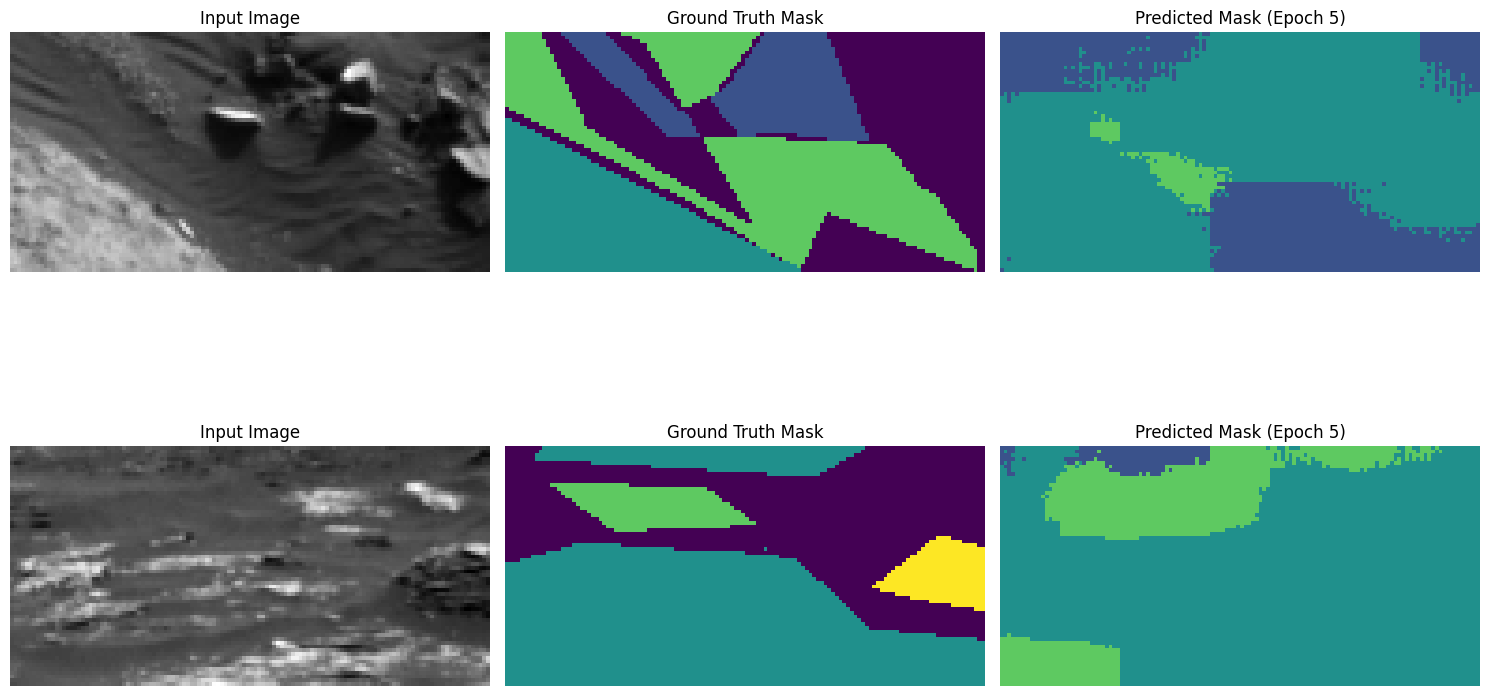

376/376 ━━━━━━━━━━━━━━━━━━━━ 79s 210ms/step - accuracy: 0.4793 - loss: 0.0529 - mean_iou: 0.3613 - val_accuracy: 0.5737 - val_loss: 0.0453 - val_mean_iou: 0.4609 - learning_rate: 1.0000e-04
Epoch 6/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5211 - loss: 0.0478 - mean_iou: 0.4077

Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 6: val_mean_iou improved to 0.4784, saving model.

Epoch 6: val_loss improved from 0.04534 to 0.04055, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


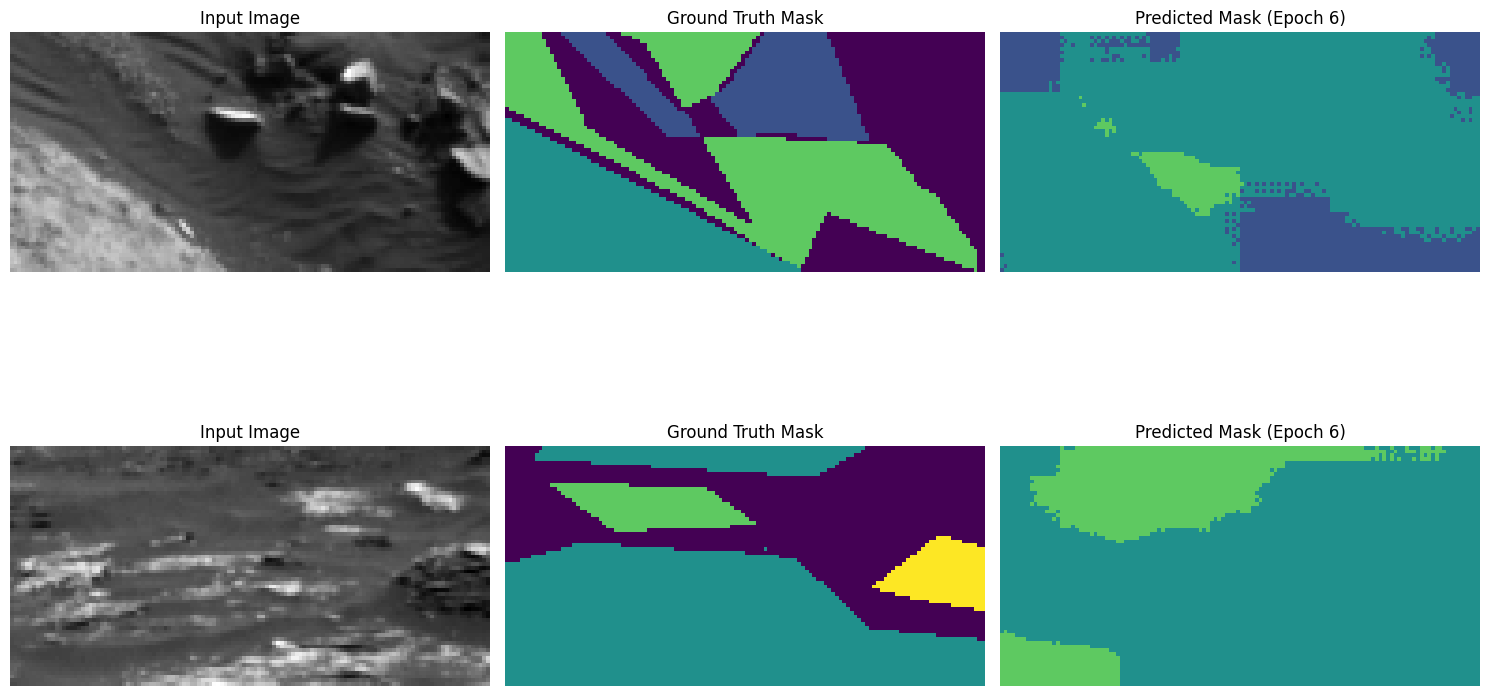

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 211ms/step - accuracy: 0.5211 - loss: 0.0478 - mean_iou: 0.4077 - val_accuracy: 0.5895 - val_loss: 0.0405 - val_mean_iou: 0.4784 - learning_rate: 1.0000e-04
Epoch 7/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5401 - loss: 0.0445 - mean_iou: 0.4305

Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 7: val_mean_iou improved to 0.4924, saving model.

Epoch 7: val_loss improved from 0.04055 to 0.03884, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


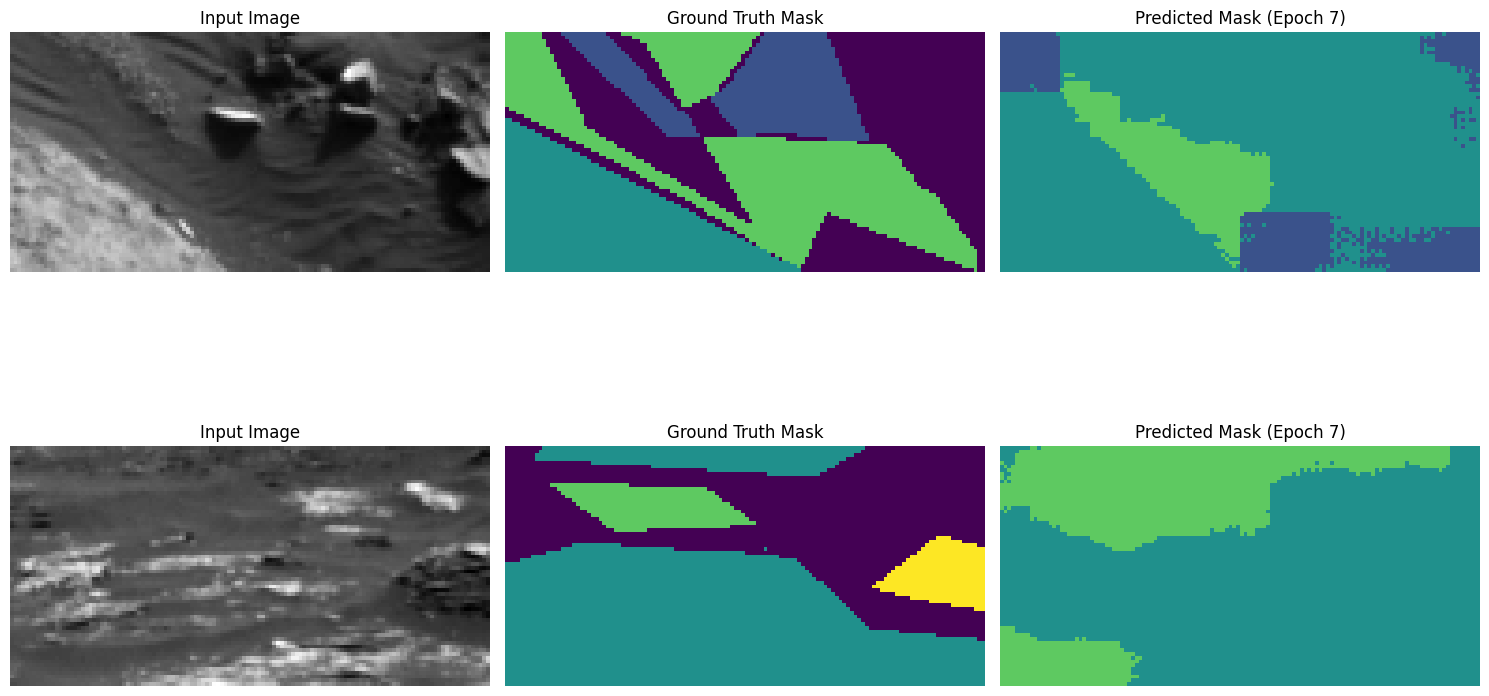

376/376 ━━━━━━━━━━━━━━━━━━━━ 81s 208ms/step - accuracy: 0.5401 - loss: 0.0445 - mean_iou: 0.4304 - val_accuracy: 0.5991 - val_loss: 0.0388 - val_mean_iou: 0.4924 - learning_rate: 1.0000e-04
Epoch 8/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5527 - loss: 0.0416 - mean_iou: 0.4458

Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 8: val_mean_iou improved to 0.5089, saving model.

Epoch 8: val_loss improved from 0.03884 to 0.03659, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


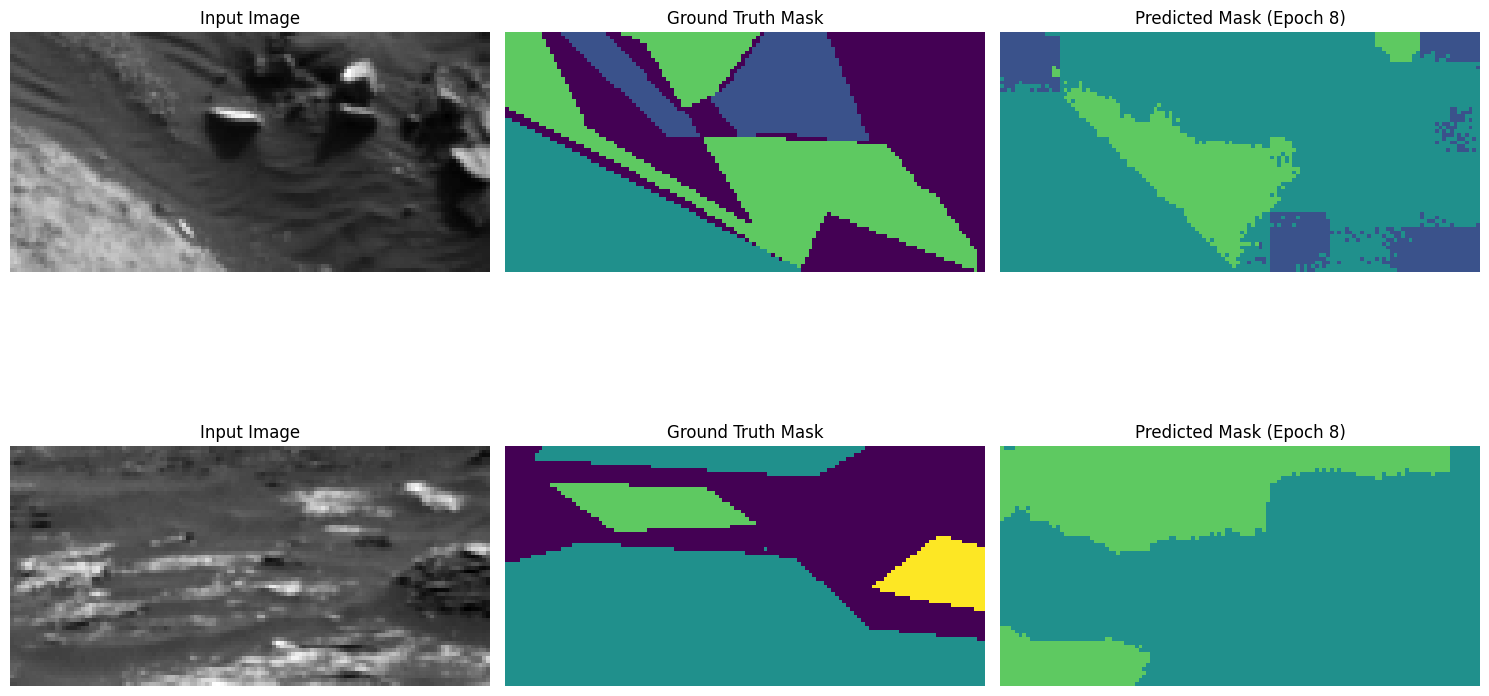

376/376 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - accuracy: 0.5527 - loss: 0.0416 - mean_iou: 0.4458 - val_accuracy: 0.6111 - val_loss: 0.0366 - val_mean_iou: 0.5089 - learning_rate: 1.0000e-04
Epoch 9/1000
113/376 ━━━━━━━━━━━━━━━━━━━━ 49s 189ms/step - accuracy: 0.5521 - loss: 0.0412 - mean_iou: 0.4529

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)
def focal_dice_loss(class_weights, gamma=2.0, alpha=0.25, smooth=1e-6):
    def loss(y_true, y_pred):
        # One-hot encode y_true
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(class_weights))

        # Sıkıştır (fazladan kanal boyutunu kaldır)
        if len(y_true_one_hot.shape) > len(y_pred.shape):
            y_true_one_hot = tf.squeeze(y_true_one_hot, axis=-2)  # Fazladan boyutu sıkıştır

        # y_pred'in değerlerini sınırlı bir aralıkta tut
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        # Focal Loss
        ce_loss = -y_true_one_hot * tf.math.log(y_pred)
        focal_loss = alpha * tf.pow(1 - y_pred, gamma) * ce_loss
        focal_loss = tf.reduce_mean(tf.reduce_sum(class_weights * focal_loss, axis=-1))

        # Dice Loss
        intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=(1, 2))
        denominator = tf.reduce_sum(y_true_one_hot + y_pred, axis=(1, 2))
        #dice_loss = 1 - (2 * intersection * class_weights + smooth) / (denominator * class_weights + smooth)
        dice_loss = 1 - (2 * intersection + smooth) / (denominator + smooth)
        dice_loss = tf.reduce_mean(dice_loss)

        # Total Loss
        total_loss = focal_loss + dice_loss
        return total_loss
    return loss
def focal_loss_with_bg_mask(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        # Create a mask to exclude background pixels (assuming class 0 is background)
        background_mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)  # Mask for non-background pixels
        # One-hot encode y_true
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)

        # Remove unnecessary dimensions
        if len(y_true_one_hot.shape) > len(y_pred.shape):
            y_true_one_hot = tf.squeeze(y_true_one_hot, axis=-2)

        # Clip y_pred values to avoid log issues
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        # Focal Loss
        ce_loss = -y_true_one_hot * tf.math.log(y_pred)
        focal_loss = alpha * tf.pow(1 - y_pred, gamma) * ce_loss

        # Apply the background mask to the focal loss
        # Reshape background_mask to match focal_loss dimensions
        background_mask = tf.expand_dims(background_mask, axis=-1)  # Add channel dimension
        if len(background_mask.shape) > len(focal_loss.shape):
           background_mask = tf.squeeze(background_mask, axis=-2)

        focal_loss = focal_loss * background_mask  # Apply mask directly to focal loss

        focal_loss = tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

        return focal_loss
    return loss

# Initialize the model
input_shape = X_train.shape[1:]
num_classes = 5  # Replace with your number of classes
ignore_class = 0  # Class to ignore

#custom_mean_iou = CustomMeanIoU(num_classes=num_classes, ignore_class=0)

model = unet_with_residual_blocks(input_shape, num_classes)

# Calculate pixel counts for each class
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class

# Set weight for background (class 0) to 0
class_weights = np.zeros(num_classes)
non_background_pixels = np.sum(class_pixel_counts[1:])  # Sum of all non-background pixels

# Calculate weights for non-background classes
for i in range(1, num_classes):  # Exclude class 0
    class_weights[i] = non_background_pixels / (class_pixel_counts[i] + 1e-6)

# Normalize only non-background class weights
class_weights[1:] /= np.sum(class_weights[1:])

print("Class Weights:", class_weights)


# Compile the model with the new loss function
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=focal_loss_with_bg_mask(),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)



model.summary()
# Define callbacks
save_best_miou = SaveBestMeanIoU(filepath="best_model_mean_iou.h5", monitor="val_mean_iou", mode="max", verbose=1)


# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    #batch_size=32,
    epochs=1000,
    callbacks=[save_best_miou, early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)


In [ ]:
# Load the saved model
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the saved best model
#best_model = tf.keras.models.load_model("best_model_mean_iou.h5", custom_objects={"MeanIoU": tf.keras.metrics.MeanIoU})

# Predict on validation data
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=-1)  # Convert to class predictions

# Reshape the true labels to match the predictions
y_val_true = y_val.squeeze()  # Remove channel dimension if present

# Initialize variables to store IoU per class
num_classes = 5
ious = []

# Compute IoU for each class
for class_id in range(1,num_classes):
    true_class = (y_val_true == class_id).astype(int)
    pred_class = (y_val_pred_classes == class_id).astype(int)
    intersection = np.sum(true_class * pred_class)
    union = np.sum(true_class + pred_class) - intersection
    iou = intersection / union if union > 0 else 0.0
    ious.append(iou)
    print(f"Class {class_id} IoU: {iou:.4f}")

# Display mean IoU
mean_iou = np.mean([iou for iou in ious])  # Exclude zero IoUs
print(f"Mean IoU (excluding zero IoUs): {mean_iou:.4f}")


In [ ]:
# Load the saved model
best_model = tf.keras.models.load_model("best_model.keras",compile=False)



In [ ]:
model=best_model

In [ ]:
model_filename = f"model_best_augmented_hvr_best_invert_noise.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [ ]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
print(f"X_test shape before reshaping: {X_test.shape}")

In [ ]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis",vmin=0,vmax=4)
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [ ]:
len(submission_df.columns)

In [ ]:
len(submission_df)

In [ ]:
"""import numpy as np
import tensorflow as tf
from skimage.util import random_noise
import matplotlib.pyplot as plt

# Define augmentation functions
def add_noise(image, amount=0.02):
    """Add salt and pepper noise."""
    return np.clip(random_noise(image, mode="s&p", amount=amount), 0, 1)

def adjust_brightness(image, delta):
    """Adjust the brightness of an image."""
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    adjusted = tf.image.adjust_brightness(image_tensor, delta=delta)
    return np.clip(adjusted.numpy(), 0, 1)

def invert_image(image):
    """Invert the grayscale image."""
    return 1.0 - image

def random_flip(image):
    """Randomly flip the image horizontally or vertically."""
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
    if np.random.rand() > 0.5:
        image = np.flipud(image)
    return image
# Randomly select 5 images for visualization
random_indices = np.random.choice(len(X_test), size=5, replace=False)
selected_images = X_test[random_indices]

# Visualize augmentations
for idx, image in enumerate(selected_images):
    plt.figure(figsize=(15, 5))

    # Original
    plt.subplot(1, 6, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Add noise
    noisy_image = add_noise(image)
    plt.subplot(1, 6, 2)
    plt.imshow(noisy_image, cmap="gray")
    plt.title("Noise")
    plt.axis("off")

    # Adjust brightness
    brighter_image = adjust_brightness(image, 0.2)
    plt.subplot(1, 6, 3)
    plt.imshow(brighter_image, cmap="gray")
    plt.title("Brighter")
    plt.axis("off")

    darker_image = adjust_brightness(image, -0.2)
    plt.subplot(1, 6, 4)
    plt.imshow(darker_image, cmap="gray")
    plt.title("Darker")
    plt.axis("off")

    # Invert
    inverted_image = invert_image(image)
    plt.subplot(1, 6, 5)
    plt.imshow(inverted_image, cmap="gray")
    plt.title("Inverted")
    plt.axis("off")

    # Random Flip
    flipped_image = random_flip(image)
    plt.subplot(1, 6, 6)
    plt.imshow(flipped_image, cmap="gray")
    plt.title("Flipped")
    plt.axis("off")

    plt.tight_layout()
    plt.show()"""
